rerun but train give macrof1 then test give both macro and weighted f1
then add the classification tabel to ALLL of the sub models as well

In [451]:
import pandas as pd
import requests
from PIL import Image
from io import BytesIO
import os
import seaborn as sns
import matplotlib.pyplot as plt

from torch.utils.data import Dataset
from sklearn.utils.class_weight import compute_class_weight
from torchvision import transforms
from PIL import Image
import torch
from transformers import BertTokenizer
from torchvision import models

from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm

from peft import get_peft_model, LoraConfig, TaskType

import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score


In [452]:
train_df = pd.read_csv("../data/fakeddit_train.tsv", sep = "\t")
val_df = pd.read_csv("../data/fakeddit_val.tsv", sep = "\t")
test_df = pd.read_csv("../data/fakeddit_test.tsv", sep = "\t")
#images in images folder with name: f"{id}.jpg"


In [453]:
# class weighting: due to class imbalance
y_train = train_df['3_way_label']

classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float)
class_weights = class_weights.to(DEVICE)

# to use this as loss later
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

Text & Image pytorch dataset
Text only pytorch dataset
Image only pytorch dataset

In [454]:
class NewsMultimodalDataset(Dataset):
    """Return dict: input_ids, attention_mask, image, label"""
    def __init__(self, df, tokenizer, transform, img_dir="../data/images", max_len=32):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.transform = transform
        self.img_dir = img_dir
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        title = str(row['clean_title']) if 'clean_title' in row.index else ""
        # ensure label is Python int
        label = int(row['3_way_label'])

        # Text tokenization
        tokens = self.tokenizer(
            title,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )
        input_ids = tokens['input_ids'].squeeze(0)
        attention_mask = tokens['attention_mask'].squeeze(0)

        # Image loading
        image_path = os.path.join(self.img_dir, f"{row['id']}.jpg")
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image not found: {image_path}")
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image) 

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'image': image,
            'label': torch.tensor(label, dtype=torch.long)
        }

class TextOnlyDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=32):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        title = str(row['clean_title']) if 'clean_title' in row.index else ""
        label = int(row['3_way_label'])
        tokens = self.tokenizer(
            title,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': tokens['input_ids'].squeeze(0),
            'attention_mask': tokens['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

class ImageOnlyDataset(Dataset):
    def __init__(self, df, transform, img_dir="../data/images"):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.img_dir = img_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        label = int(row['3_way_label'])
        image_path = os.path.join(self.img_dir, f"{row['id']}.jpg")
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image not found: {image_path}")
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)
        return {
            'image': image,
            'label': torch.tensor(label, dtype=torch.long)
        }


Dataloader

In [455]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# text dataset to dataloader
train_text = TextOnlyDataset(train_df, tokenizer)
val_text = TextOnlyDataset(val_df, tokenizer)
test_text = TextOnlyDataset(test_df, tokenizer)

train_text_loader = DataLoader(train_text, batch_size=16, shuffle=True)
val_text_loader = DataLoader(val_text, batch_size=16, shuffle=True)
test_text_loader = DataLoader(test_text, batch_size=16, shuffle=True)

# image dataset to dataloader
train_image = ImageOnlyDataset(train_df, transform)
val_image = ImageOnlyDataset(val_df, transform)
test_image = ImageOnlyDataset(test_df, transform)

train_image_loader = DataLoader(train_image, batch_size=16, shuffle=True)
val_image_loader = DataLoader(val_image, batch_size=16, shuffle=True)
test_image_loader = DataLoader(test_image, batch_size=16, shuffle=True)

# text and image dataset to loader
train_ds = NewsMultimodalDataset(train_df, tokenizer, transform)
val_ds = NewsMultimodalDataset(val_df, tokenizer, transform)
test_ds = NewsMultimodalDataset(test_df, tokenizer, transform)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=16, shuffle=False)

BERT + RESNET & Fusion
late/feature fusion: Extract separate embeddings from each modality, then concatenate them before classification.

BERT model

In [456]:

class TextClassifier(nn.Module):
    def __init__(self, text_model_name="bert-base-uncased", num_labels=3, freeze_bert=False):
        super().__init__()
        self.bert = BertModel.from_pretrained(text_model_name)
        self.config = self.bert.config  
        hidden = self.bert.config.hidden_size
        self.classifier = nn.Linear(hidden, num_labels)

        if freeze_bert:
            for p in self.bert.parameters():
                p.requires_grad = False

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.pooler_output
        return self.classifier(pooled)

# LoRA config
config = LoraConfig(
    task_type=TaskType.FEATURE_EXTRACTION,
    r=8,
    lora_alpha=32,
    lora_dropout=0.2,
    target_modules=["query", "value"]
)

# apply LoRA to BERT first, not to classifier
bert = BertModel.from_pretrained("bert-base-uncased")
bert = get_peft_model(bert, config)

# wrap the LoRA-BERT in classifier
text_model = TextClassifier(num_labels=3)
text_model.bert = bert


ResNet model

In [457]:
class ImageClassifier(nn.Module):
    def __init__(self, num_labels=3):
        super().__init__()
        self.backbone = resnet50(weights=ResNet50_Weights.DEFAULT)
        in_feat = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_feat, num_labels)
        )
        
        # Freeze all params
        for p in self.backbone.parameters():
            p.requires_grad = False

        # Unfreeze last residual block
        for name, p in self.backbone.layer4.named_parameters():
            p.requires_grad = True
        # Unfreeze final classifier
        for p in self.backbone.fc.parameters():
            p.requires_grad = True

    def forward(self, image):
        return self.backbone(image)


Fusion of BERT and ResNet

In [458]:
class BertResNetLateFusion(nn.Module):
    def __init__(self, 
                 text_model_path="bert_text_only.pt", 
                 image_model_path="resnet_image_only.pt", 
                 num_classes=3, 
                 freeze_encoders=True):
        super().__init__()
        self.text_dropout = nn.Dropout(0.2)  
        self.img_dropout = nn.Dropout(0.2)

        # Load pretrained BERT
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.text_fc = nn.Linear(768, 512)  # reduce to 512-dim

        if text_model_path:
            try:
                text_state = torch.load(text_model_path, map_location="cpu")
                # Load only BERT weights (not classifier)
                bert_weights = {k.replace('bert.', ''): v for k, v in text_state.items() if 'bert.' in k}
                self.bert.load_state_dict(bert_weights, strict=False)
                print("Loaded pretrained BERT weights")
            except Exception as e:
                print(f"Could not load BERT weights: {e}")

        # Load pretrained ResNet
        resnet = models.resnet50(weights=None)
        resnet.fc = nn.Identity()
        self.resnet = resnet
        self.img_fc = nn.Linear(2048, 512)

        if image_model_path:
            try:
                image_state = torch.load(image_model_path, map_location="cpu")
                resnet_weights = {k.replace('resnet.', ''): v for k, v in image_state.items() if 'resnet.' in k}
                self.resnet.load_state_dict(resnet_weights, strict=False)
                print("Loaded pretrained ResNet weights")
            except Exception as e:
                print(f"Could not load ResNet weights: {e}")

        # Freeze fine-tuned encoders
        if freeze_encoders:
            for p in self.bert.parameters():
                p.requires_grad = False
            for p in self.resnet.parameters():
                p.requires_grad = False

            # Unfreeze last layers
            for name, param in self.bert.named_parameters():
                if "encoder.layer.11" in name or "pooler" in name:
                    param.requires_grad = True

            for name, param in self.resnet.named_parameters():
                if "layer4" in name:
                    param.requires_grad = True

        # Fusion head
        self.alpha = nn.Parameter(torch.tensor(0.5))  # learnable fusion weight
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )

    # Forward pass
    def forward(self, input_ids, attention_mask, image):
        # Text embedding
        text_out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        text_emb = self.text_fc(text_out.pooler_output)
        text_emb = self.text_dropout(text_emb)

        # Image embedding
        img_emb = self.img_fc(self.resnet(image))
        img_emb = self.img_dropout(img_emb)

        # Weighted fusion
        fused_emb = self.alpha * text_emb + (1 - self.alpha) * img_emb
        logits = self.classifier(fused_emb)
        return logits



Train BERT text model - 2e-5 overfits

In [459]:
def evaluate_text_model(model, loader):
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = outputs.argmax(dim=1).cpu()
            all_p.extend(preds.cpu().numpy())
            all_l.extend(batch["label"].cpu().numpy())
            all_preds.extend(preds)
            all_labels.extend(labels.cpu())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(labels, preds, average='weighted')
    macro_f1 = f1_score(labels, preds, average='macro')
    avg_loss = total_loss/len(loader)
    return avg_loss, acc, f1, macro_f1


In [460]:
tr_loss = []
v_loss = []
ac = []
vac = []
f = []
vf = []
mac_f1 = []
vmac_f1 = []

def train_text_model(model, train_loader, val_loader, epochs=5, lr=1e-6): # decreased learning rate
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        all_preds, all_labels = [], []

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            preds = outputs.argmax(dim=1).detach().cpu()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu())

        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='weighted')
        macro_f1 = f1_score(all_labels, all_preds, average='macro')
        avg_loss = total_loss/len(train_loader)
        tr_loss.append(avg_loss)
        ac.append(acc)
        f.append(f1)
        mac_f1.append(macro_f1)
        print(f"Epoch {epoch+1} | Train Loss: {avg_loss:.4f}, Accuracy: {acc:.4f}, Weighted F1: {f1:.4f}, Macro F1: {macro_f1:.4f}")
        
        vloss, vacc, vf1, mf1 = evaluate_text_model(model, val_loader)
        v_loss.append(vloss)
        vac.append(vacc)
        vf.append(vf1)
        vmac_f1.append(mf1)
        print(f"Validation Loss: {vloss:.4f}, Accuracy: {vacc:.4f}, Weighted F1: {vf1:.4f}, Macro F1: {mf1:.4f}")
    return model


In [461]:
text_model = TextClassifier().to(device)
text_model = train_text_model(text_model, train_text_loader, val_text_loader)

Epoch 1: 100%|██████████| 1886/1886 [23:02<00:00,  1.36it/s]


Epoch 1 | Train Loss: 0.8533, Accuracy: 0.6356, Weighted F1: 0.6385, Macro F1: 0.5709
Validation Loss: 0.6002, Accuracy: 0.7145, Weighted F1: 0.5292, Macro F1: 0.6104


Epoch 2: 100%|██████████| 1886/1886 [22:08<00:00,  1.42it/s]


Epoch 2 | Train Loss: 0.5650, Accuracy: 0.7294, Weighted F1: 0.7303, Macro F1: 0.6970
Validation Loss: 0.5130, Accuracy: 0.7556, Weighted F1: 0.4410, Macro F1: 0.2872


Epoch 3: 100%|██████████| 1886/1886 [22:04<00:00,  1.42it/s]


Epoch 3 | Train Loss: 0.4941, Accuracy: 0.7593, Weighted F1: 0.7598, Macro F1: 0.7444
Validation Loss: 0.4766, Accuracy: 0.7821, Weighted F1: 0.9135, Macro F1: 0.9302


Epoch 4: 100%|██████████| 1886/1886 [22:02<00:00,  1.43it/s]


Epoch 4 | Train Loss: 0.4493, Accuracy: 0.7810, Weighted F1: 0.7815, Macro F1: 0.7767
Validation Loss: 0.4645, Accuracy: 0.7789, Weighted F1: 0.8333, Macro F1: 0.8778


Epoch 5: 100%|██████████| 1886/1886 [21:59<00:00,  1.43it/s]


Epoch 5 | Train Loss: 0.4187, Accuracy: 0.7946, Weighted F1: 0.7949, Macro F1: 0.7970
Validation Loss: 0.4544, Accuracy: 0.7964, Weighted F1: 0.9172, Macro F1: 0.9161


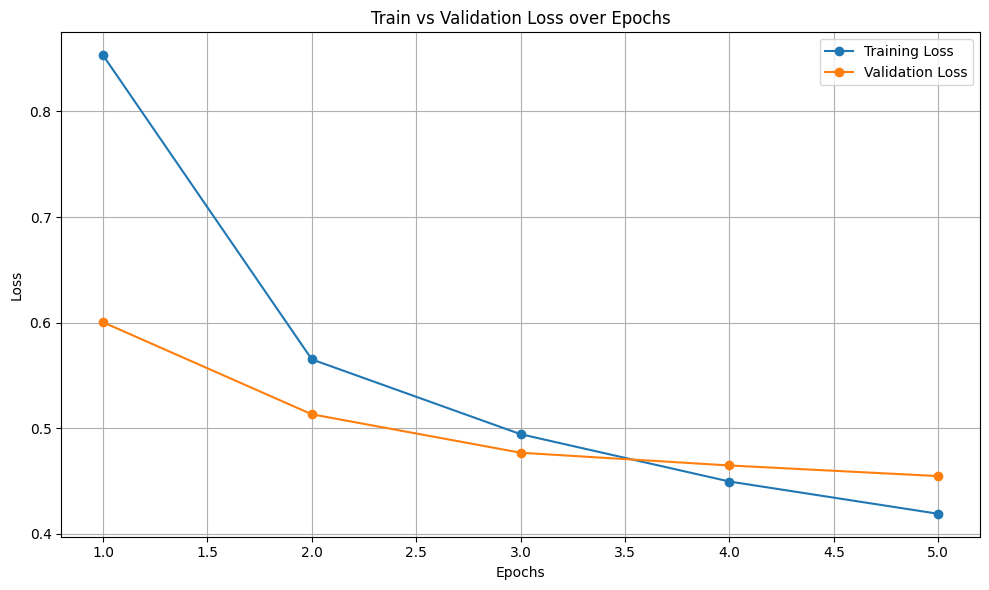

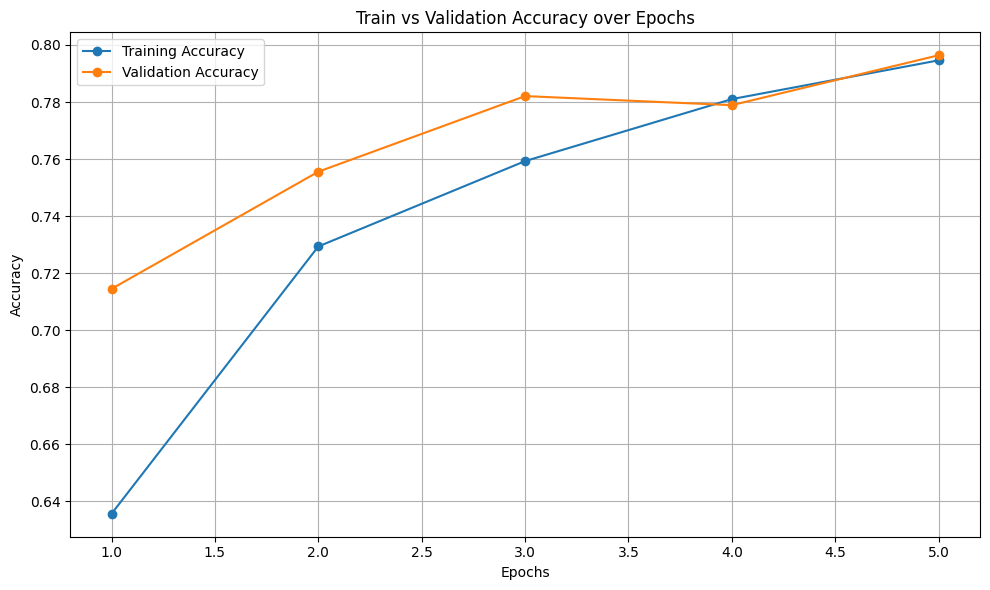

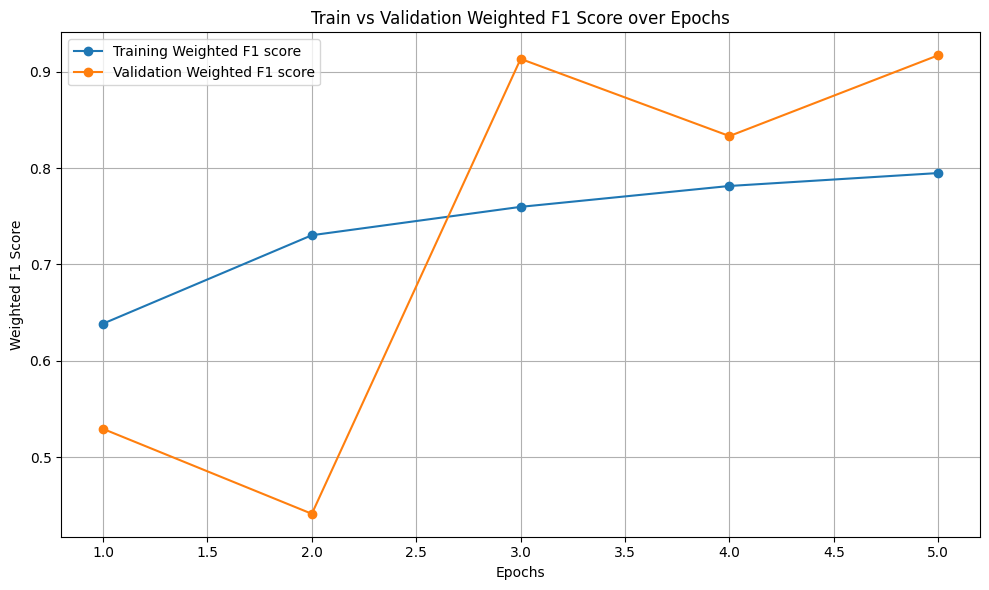

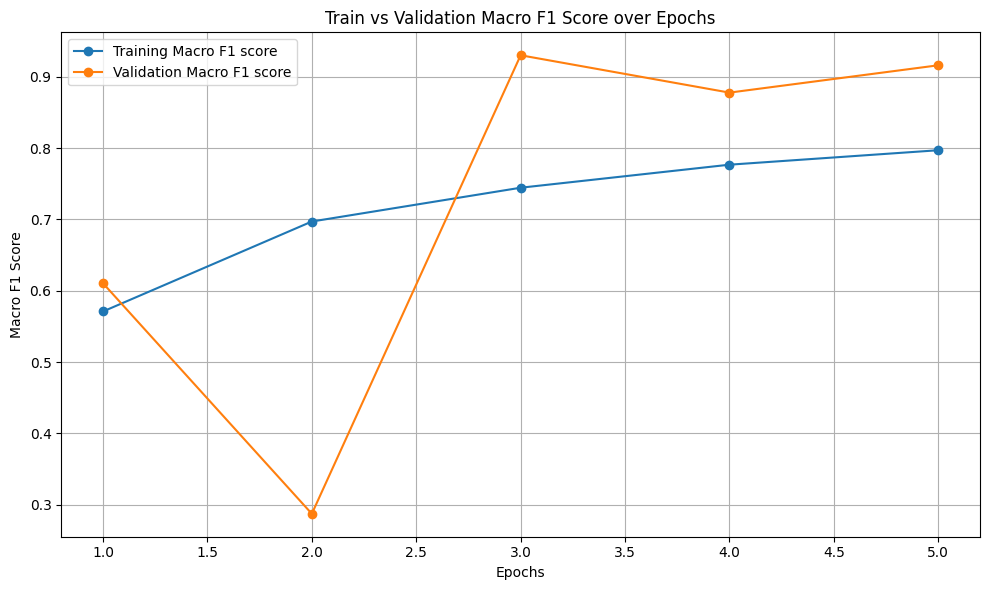

In [462]:
# Plots
EPOCHS = 5

# Training vs Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS+1), tr_loss, marker='o', label='Training Loss')
plt.plot(range(1, EPOCHS+1), v_loss, marker='o', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss over Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Train vs Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS+1), ac, marker='o', label='Training Accuracy')
plt.plot(range(1, EPOCHS+1), vac, marker='o', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy over Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Train vs Validation F1 Score
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS+1), f, marker='o', label='Training Weighted F1 score')
plt.plot(range(1, EPOCHS+1), vf, marker='o', label='Validation Weighted F1 score')
plt.xlabel('Epochs')
plt.ylabel('Weighted F1 Score')
plt.title('Train vs Validation Weighted F1 Score over Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Train vs Validation Macro F1 Score
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS+1), mac_f1, marker='o', label='Training Macro F1 score')
plt.plot(range(1, EPOCHS+1), vmac_f1, marker='o', label='Validation Macro F1 score')
plt.xlabel('Epochs')
plt.ylabel('Macro F1 Score')
plt.title('Train vs Validation Macro F1 Score over Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Text only BERT model performance on test set

In [463]:
# collect predictions and labels
all_preds, all_labels = [], []
test_loss, test_acc, test_wf1, test_mf1  = evaluate_text_model(text_model, test_text_loader)
print("Perfromance of Text only BERT model on test data:")
print(f"Test loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}, Weighted F1: {test_f1:.4f}, Macro F1: {test_mf1:.4f}")

Perfromance of Text only BERT model on test data:
Test loss: 0.4694, Accuracy: 0.7927, Weighted F1: 0.4051, Macro F1: 0.8690


In [464]:
# define label names
label_names = ['True', 'Misleading', 'Fake']

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Collect predictions and labels
all_preds, all_labels = [], []

text_model.eval() 

loop = tqdm(test_loader, desc='Testing')
with torch.no_grad():
    for batch in loop:
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels = batch["label"].to(DEVICE)

        logits = text_model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(logits, dim=-1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print classification report
report = classification_report(all_labels, all_preds, target_names=label_names, digits=4)
print('\n=== Classification Report (BERT Model) ===\n')
print(report)

Testing: 100%|██████████| 236/236 [00:45<00:00,  5.21it/s]


=== Classification Report (BERT Model) ===

              precision    recall  f1-score   support

        True     0.8229    0.8236    0.8232      2081
  Misleading     0.6872    0.9044    0.7810       136
        Fake     0.7636    0.7415    0.7524      1555

    accuracy                         0.7927      3772
   macro avg     0.7579    0.8232    0.7855      3772
weighted avg     0.7935    0.7927    0.7925      3772



Save BERT model for fusion later

In [465]:
torch.save(text_model.state_dict(), "bert_text_only.pt")

Train Image only ResNet model

In [466]:
def evaluate_image_model(model, loader):
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0

    with torch.no_grad():
        for batch in loader:
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = outputs.argmax(dim=1).cpu()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(labels, preds, average='weighted')
    macro_f1 = f1_score(labels, preds, average='macro')
    avg_loss = total_loss/len(loader)
    return avg_loss, acc, f1, macro_f1

In [467]:
tr_loss = []
v_loss = []
ac = []
vac = []
f = []
vf = []
mac_f1 = []
vmac_f1 = []

def train_image_model(model, train_loader, val_loader, epochs=5, lr=1e-5): # reduced learning rate
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4) # added weight decay
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        all_preds, all_labels = [], []

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            optimizer.zero_grad()
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            preds = outputs.argmax(dim=1).detach().cpu()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu())

        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='weighted')
        macro_f1 = f1_score(all_labels, all_preds, average='macro')
        avg_loss = total_loss/len(train_loader)
        tr_loss.append(avg_loss)
        ac.append(acc)
        f.append(f1)
        mac_f1.append(macro_f1)
        print(f"Epoch {epoch+1} | Train Loss: {avg_loss:.4f}, Acc: {acc:.4f}, Weighted F1: {f1:.4f}, Macro F1: {macro_f1:.4f}")

        vloss, vacc, vf1, mf1 = evaluate_image_model(model, val_loader)
        v_loss.append(vloss)
        vac.append(vacc)
        vf.append(vf1)
        vmac_f1.append(mf1)
        print(f"Validation Loss: {vloss:.4f}, Accuracy: {vacc:.4f}, Weighted F1: {vf1:.4f}, Macro F1: {mf1:.4f}")
    return model

In [468]:
image_model = ImageClassifier().to(device)
image_model = train_image_model(image_model, train_image_loader, val_image_loader)

Epoch 1: 100%|██████████| 1886/1886 [1:19:42<00:00,  2.54s/it]


Epoch 1 | Train Loss: 0.8695, Acc: 0.5555, Weighted F1: 0.5611, Macro F1: 0.4994
Validation Loss: 0.7431, Accuracy: 0.6172, Weighted F1: 0.7405, Macro F1: 0.7905


Epoch 2: 100%|██████████| 1886/1886 [1:18:52<00:00,  2.51s/it]


Epoch 2 | Train Loss: 0.7167, Acc: 0.6235, Weighted F1: 0.6266, Macro F1: 0.5750
Validation Loss: 0.6853, Accuracy: 0.6376, Weighted F1: 0.5000, Macro F1: 0.4375


Epoch 3: 100%|██████████| 1886/1886 [1:19:00<00:00,  2.51s/it]


Epoch 3 | Train Loss: 0.6623, Acc: 0.6513, Weighted F1: 0.6530, Macro F1: 0.6130
Validation Loss: 0.6584, Accuracy: 0.6546, Weighted F1: 0.7448, Macro F1: 0.7483


Epoch 4: 100%|██████████| 1886/1886 [1:19:01<00:00,  2.51s/it]


Epoch 4 | Train Loss: 0.6298, Acc: 0.6665, Weighted F1: 0.6669, Macro F1: 0.6319
Validation Loss: 0.6698, Accuracy: 0.6758, Weighted F1: 0.8333, Macro F1: 0.7778


Epoch 5: 100%|██████████| 1886/1886 [1:19:14<00:00,  2.52s/it]


Epoch 5 | Train Loss: 0.6081, Acc: 0.6846, Weighted F1: 0.6849, Macro F1: 0.6517
Validation Loss: 0.6785, Accuracy: 0.6774, Weighted F1: 0.6476, Macro F1: 0.6571


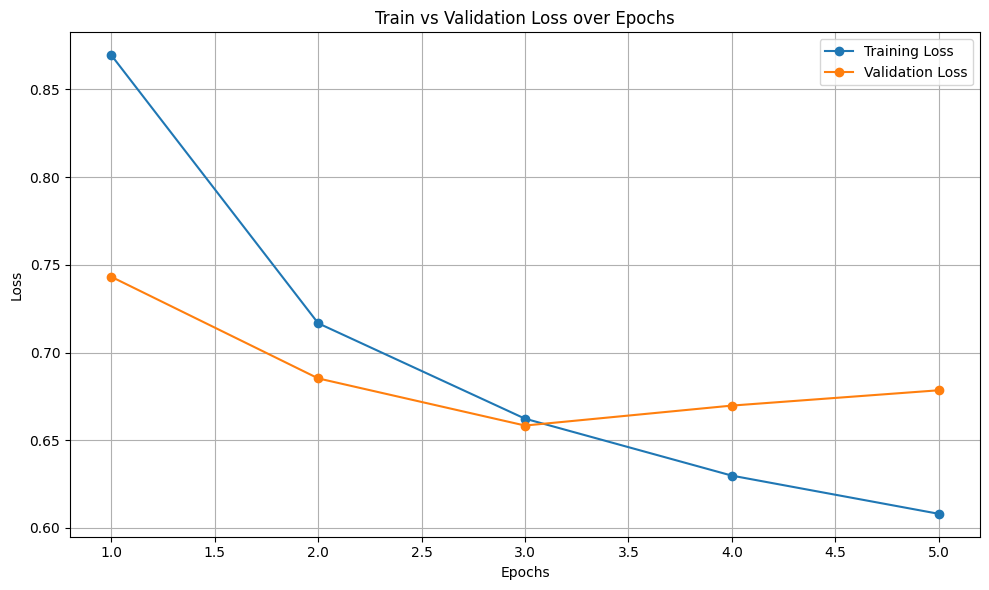

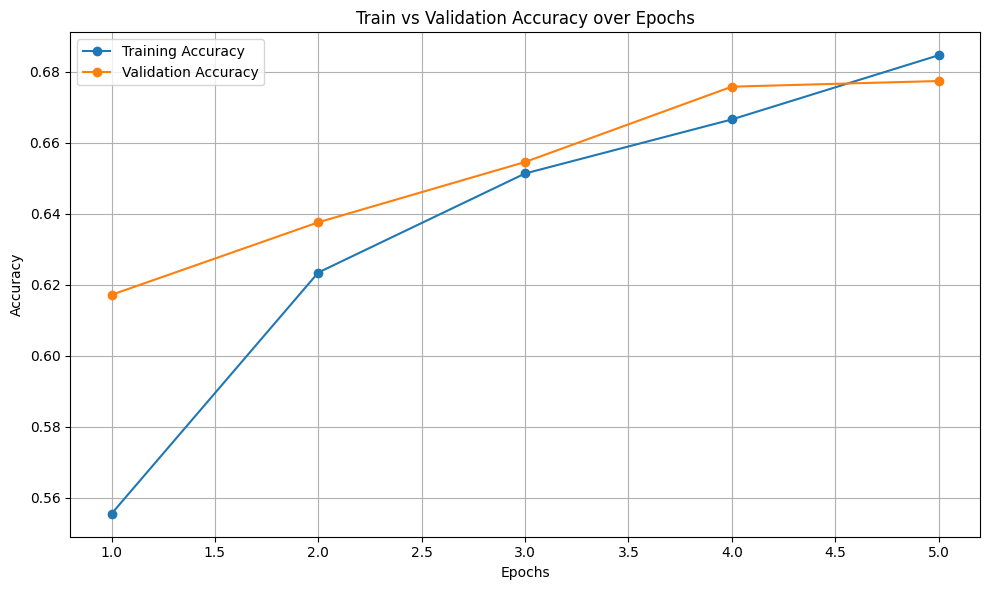

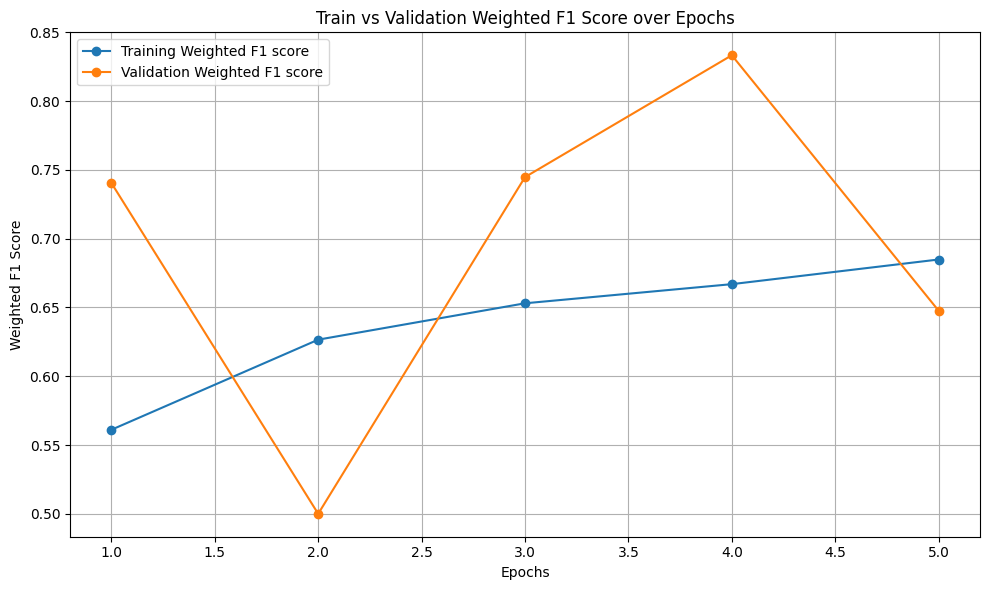

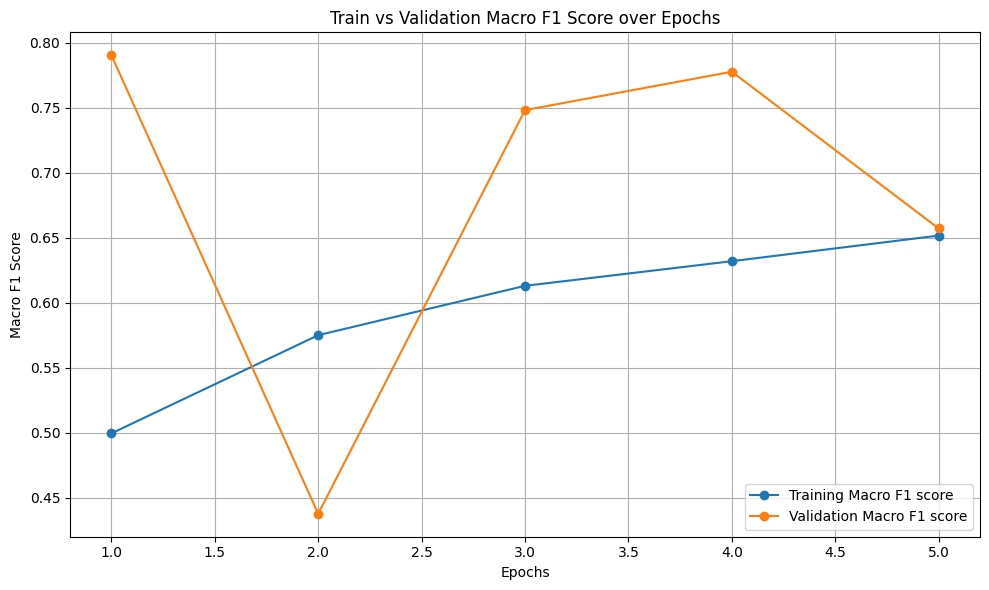

In [469]:
# plot loss, accuracy, f1

# Training vs Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS+1), tr_loss, marker='o', label='Training Loss')
plt.plot(range(1, EPOCHS+1), v_loss, marker='o', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss over Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Train vs Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS+1), ac, marker='o', label='Training Accuracy')
plt.plot(range(1, EPOCHS+1), vac, marker='o', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy over Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Train vs Validation F1 Score
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS+1), f, marker='o', label='Training Weighted F1 score')
plt.plot(range(1, EPOCHS+1), vf, marker='o', label='Validation Weighted F1 score')
plt.xlabel('Epochs')
plt.ylabel('Weighted F1 Score')
plt.title('Train vs Validation Weighted F1 Score over Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Train vs Validation Macro F1 Score
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS+1), mac_f1, marker='o', label='Training Macro F1 score')
plt.plot(range(1, EPOCHS+1), vmac_f1, marker='o', label='Validation Macro F1 score')
plt.xlabel('Epochs')
plt.ylabel('Macro F1 Score')
plt.title('Train vs Validation Macro F1 Score over Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Image only ResNet performance on test data

In [470]:
# collect predictions and labels
all_preds, all_labels = [], []
tloss, tacc, tf1, tmf1 = evaluate_image_model(image_model, test_image_loader)
print("Perfromance of Image only ResNet model on test data:")
print(f"Test loss: {tloss:.4f}, Accuracy: {tacc:.4f}, Weighted F1: {tf1:.4f}, Macro F1: {tmf1:.4f}")

Perfromance of Image only ResNet model on test data:
Test loss: 0.7015, Accuracy: 0.6797, Weighted F1: 0.4684, Macro F1: 0.4670


In [471]:
# Define label names
label_names = ['True', 'Misleading', 'Fake']

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Collect predictions and labels
all_preds, all_labels = [], []

image_model.eval()  # ensure dropout/bn layers are in eval mode

loop = tqdm(test_loader, desc='Testing')
with torch.no_grad():
    for batch in loop:
        batch = {k: v.to(DEVICE) for k, v in batch.items()}
        
        logits = image_model(batch["image"])
        
        preds = torch.argmax(logits, dim=-1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch["label"].cpu().numpy())

# Print classification report
report = classification_report(all_labels, all_preds, target_names=label_names, digits=4)
print('\n=== Classification Report (ResNet Model) ===\n')
print(report)


Testing: 100%|██████████| 236/236 [08:51<00:00,  2.25s/it]


=== Classification Report (ResNet Model) ===

              precision    recall  f1-score   support

        True     0.6961    0.8256    0.7553      2081
  Misleading     0.4534    0.7868    0.5753       136
        Fake     0.6863    0.4714    0.5589      1555

    accuracy                         0.6782      3772
   macro avg     0.6119    0.6946    0.6298      3772
weighted avg     0.6833    0.6782    0.6679      3772



save image only ResNet model

In [472]:
torch.save(image_model.state_dict(), "resnet_image_only.pt")

Train BERT and ResNet Fusion model

In [473]:
def evaluate_fusion_model(model, loader):
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask, images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = outputs.argmax(dim=1).cpu()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(labels, preds, average='weighted')
    macro_f1 = f1_score(labels, preds, average='macro')
    avg_loss = total_loss/len(loader)
    return avg_loss, acc, f1, macro_f1

In [474]:
tr_loss = []
v_loss = []
ac = []
vac = []
f = []
vf = []
mac_f1 = []
vmac_f1 = []

def train_fusion_model(model, train_loader, val_loader, epochs=5, lr=1e-6): # reduced learning rate
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=1e-4) # added weight decay
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        all_preds, all_labels = [], []

        for batch in tqdm(train_loader, desc=f"Fusion Epoch {epoch+1}"):
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask, images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            preds = outputs.argmax(dim=1).detach().cpu()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu())

        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='weighted')
        macro_f1 = f1_score(all_labels, all_preds, average='macro')
        avg_loss = total_loss/len(train_loader)
        tr_loss.append(avg_loss)
        ac.append(acc)
        f.append(f1)
        mac_f1.append(macro_f1)
        print(f"Epoch {epoch+1} | Train Loss: {avg_loss:.4f}, Acc: {acc:.4f}, Weighted F1: {f1:.4f}, Macro F1: {macro_f1:.4f}")

        vloss, vacc, vf1, mf1 = evaluate_fusion_model(model, val_loader)
        v_loss.append(vloss)
        vac.append(vacc)
        vf.append(vf1)
        vmac_f1.append(mf1)
        print(f"Validation Loss: {vloss:.4f}, Accuracy: {vacc:.4f}, Weighted F1: {vf1:.4f}, Macro F1: {mf1:.4f}")
        print(f"Current α: {fusion_model.alpha.item():.3f}")
    return model

In [475]:
fusion_model = BertResNetLateFusion(
    text_model_path="bert_text_only.pt",
    image_model_path="resnet_image_only.pt",
    num_classes=3,
    freeze_encoders=True 
)

fusion_model = train_fusion_model(fusion_model, train_loader, val_loader)

Loaded pretrained BERT weights
Loaded pretrained ResNet weights


Fusion Epoch 1: 100%|██████████| 1886/1886 [1:33:06<00:00,  2.96s/it]


Epoch 1 | Train Loss: 0.7373, Acc: 0.7702, Weighted F1: 0.7696, Macro F1: 0.7560
Validation Loss: 0.5165, Accuracy: 0.7876, Weighted F1: 0.8333, Macro F1: 0.8286
Current α: 0.502


Fusion Epoch 2: 100%|██████████| 1886/1886 [1:37:11<00:00,  3.09s/it]


Epoch 2 | Train Loss: 0.4522, Acc: 0.8007, Weighted F1: 0.8004, Macro F1: 0.8087
Validation Loss: 0.4608, Accuracy: 0.7900, Weighted F1: 0.8333, Macro F1: 0.8286
Current α: 0.503


Fusion Epoch 3: 100%|██████████| 1886/1886 [1:42:23<00:00,  3.26s/it]


Epoch 3 | Train Loss: 0.4130, Acc: 0.7999, Weighted F1: 0.7998, Macro F1: 0.8097
Validation Loss: 0.4664, Accuracy: 0.7927, Weighted F1: 0.8333, Macro F1: 0.8286
Current α: 0.504


Fusion Epoch 4: 100%|██████████| 1886/1886 [1:43:10<00:00,  3.28s/it]


Epoch 4 | Train Loss: 0.3988, Acc: 0.8044, Weighted F1: 0.8044, Macro F1: 0.8148
Validation Loss: 0.4557, Accuracy: 0.7924, Weighted F1: 0.8333, Macro F1: 0.8286
Current α: 0.504


Fusion Epoch 5: 100%|██████████| 1886/1886 [1:43:56<00:00,  3.31s/it]


Epoch 5 | Train Loss: 0.3953, Acc: 0.8041, Weighted F1: 0.8042, Macro F1: 0.8186
Validation Loss: 0.4757, Accuracy: 0.7967, Weighted F1: 0.8333, Macro F1: 0.8286
Current α: 0.504


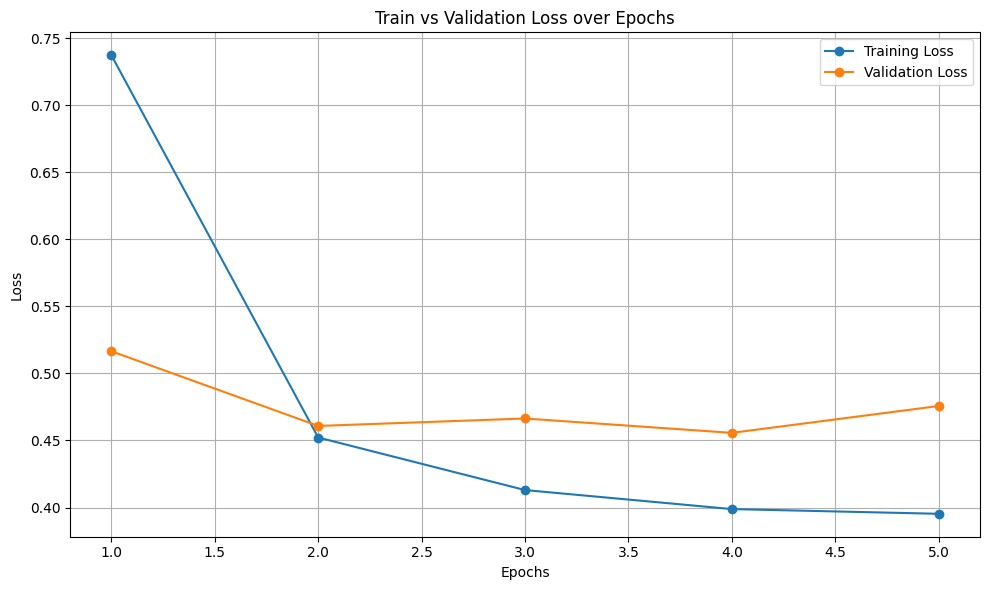

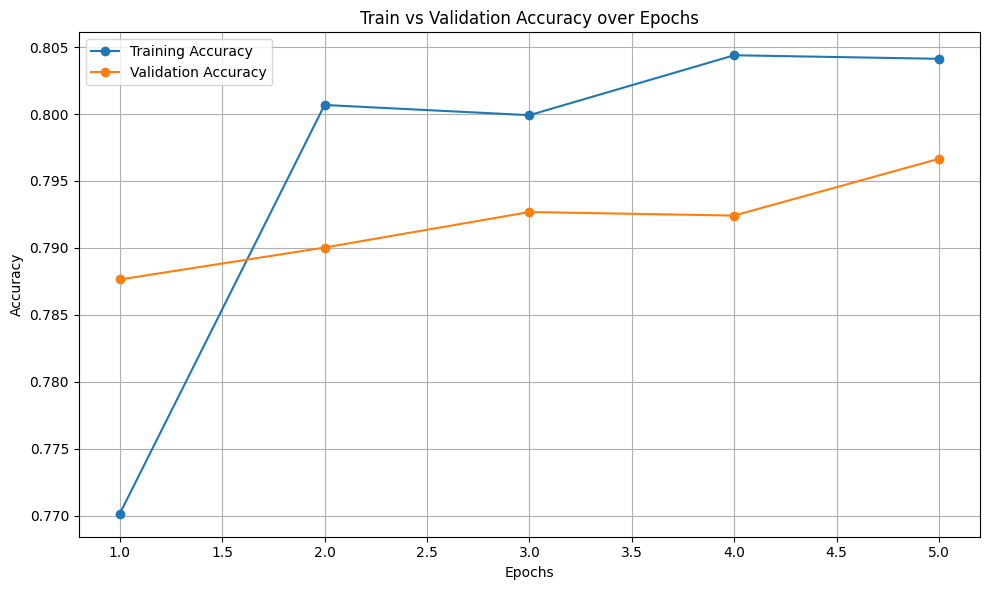

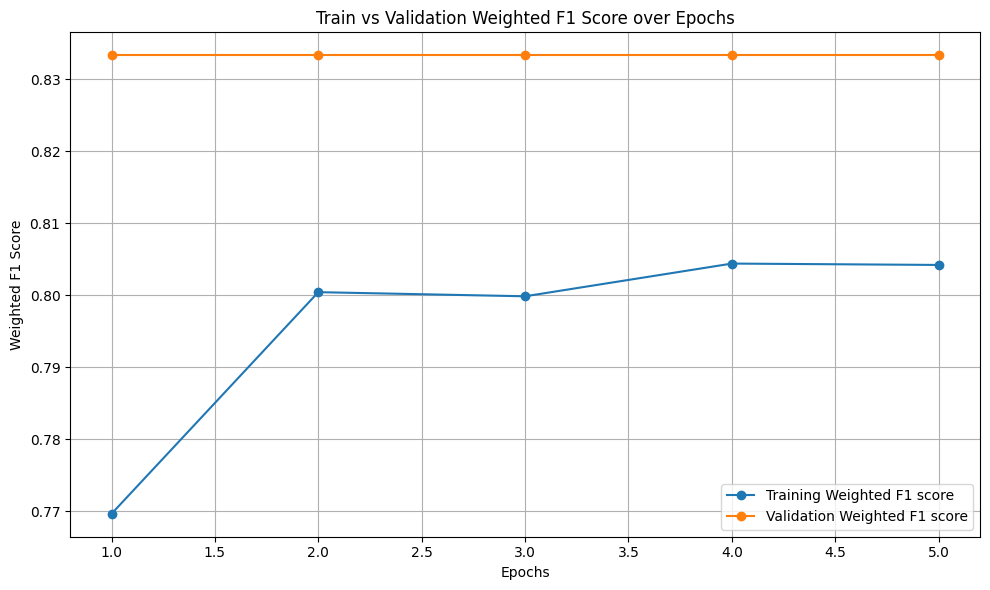

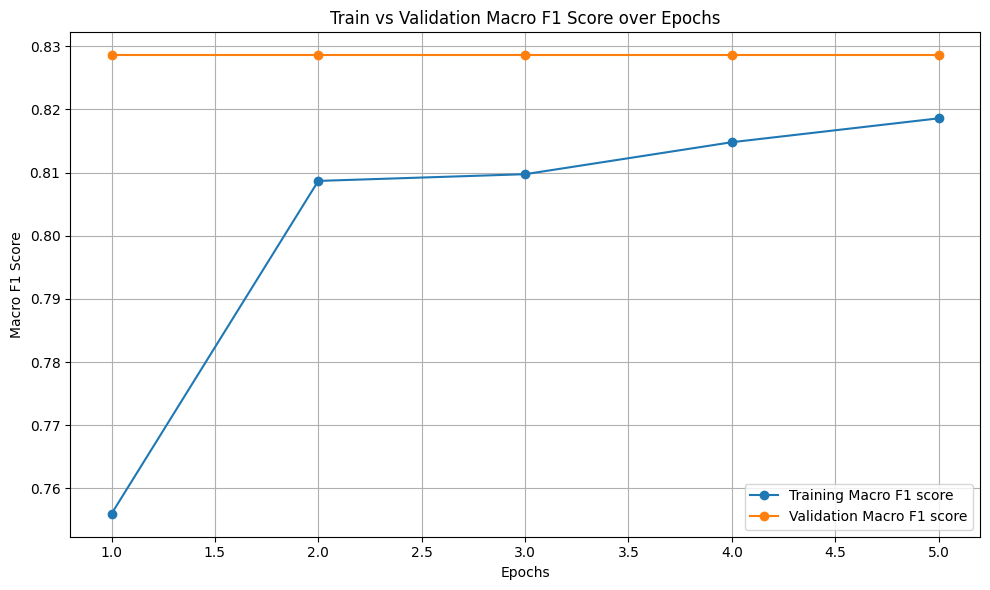

In [476]:
# plot loss, accuracy, f1

# Training vs Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS+1), tr_loss, marker='o', label='Training Loss')
plt.plot(range(1, EPOCHS+1), v_loss, marker='o', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss over Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Train vs Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS+1), ac, marker='o', label='Training Accuracy')
plt.plot(range(1, EPOCHS+1), vac, marker='o', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy over Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Train vs Validation F1 Score
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS+1), f, marker='o', label='Training Weighted F1 score')
plt.plot(range(1, EPOCHS+1), vf, marker='o', label='Validation Weighted F1 score')
plt.xlabel('Epochs')
plt.ylabel('Weighted F1 Score')
plt.title('Train vs Validation Weighted F1 Score over Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Train vs Validation Macro F1 Score
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS+1), mac_f1, marker='o', label='Training Macro F1 score')
plt.plot(range(1, EPOCHS+1), vmac_f1, marker='o', label='Validation Macro F1 score')
plt.xlabel('Epochs')
plt.ylabel('Macro F1 Score')
plt.title('Train vs Validation Macro F1 Score over Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

BERT-ResNet fusion model perfromance on test data

In [477]:
# collect predictions and labels
all_preds, all_labels = [], []
tloss, tacc, tf1, mtf1 = evaluate_fusion_model(fusion_model, test_loader)
print("Perfromance of Image and Text BERT-ResNet Fusion model on test data:")
print(f"Test loss: {tloss:.4f}, Accuracy: {tacc:.4f}, F1: {tf1:.4f}, Weighted F1: {tf1:.4f}, Macro F1: {mtf1:.4f}")

Perfromance of Image and Text BERT-ResNet Fusion model on test data:
Test loss: 0.4711, Accuracy: 0.7993, F1: 0.9167, Weighted F1: 0.9167, Macro F1: 0.8667


In [478]:
# Define label names
label_names = ['True', 'Misleading', 'Fake']

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Collect predictions and labels
all_preds, all_labels = [], []

fusion_model.eval()  

loop = tqdm(test_loader, desc='Testing')
with torch.no_grad():
    for batch in loop:
        batch = {k: v.to(DEVICE) for k, v in batch.items()}
        
        logits = fusion_model(batch["input_ids"], batch["attention_mask"], batch["image"])
        
        preds = torch.argmax(logits, dim=-1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch["label"].cpu().numpy())

# Print classification report
report = classification_report(all_labels, all_preds, target_names=label_names, digits=4)
print('\n=== Classification Report (ResNet Model) ===\n')
print(report)


Testing: 100%|██████████| 236/236 [11:04<00:00,  2.82s/it]


=== Classification Report (ResNet Model) ===

              precision    recall  f1-score   support

        True     0.8146    0.8448    0.8294      2081
  Misleading     0.7692    0.8824    0.8219       136
        Fake     0.7771    0.7286    0.7521      1555

    accuracy                         0.7983      3772
   macro avg     0.7870    0.8186    0.8011      3772
weighted avg     0.7975    0.7983    0.7973      3772



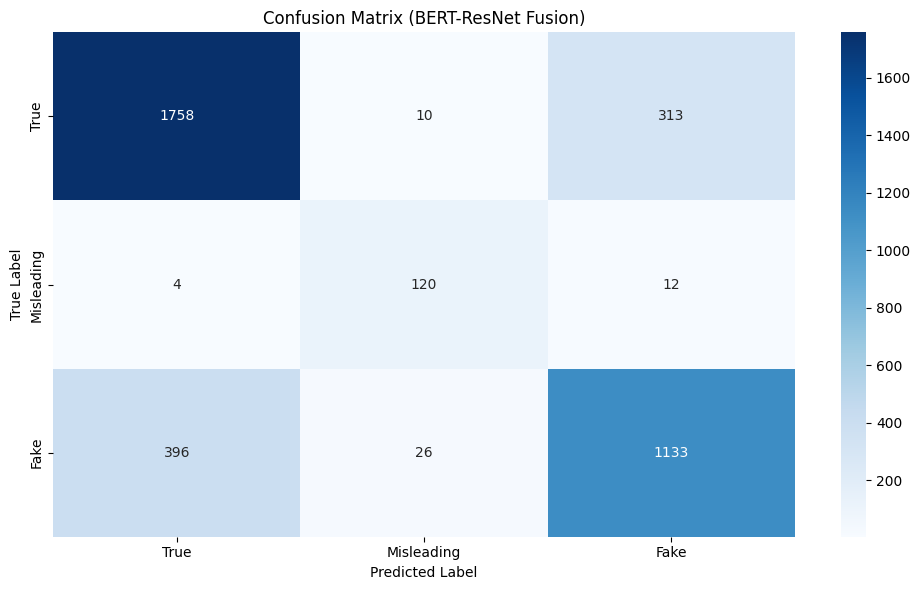

In [479]:
# plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (BERT-ResNet Fusion)')
plt.tight_layout()
plt.show()

Plot ROC-AUC curves

In [480]:
# binarize labels for ROC and precision-recall curves
y_true_bin = label_binarize(all_labels, classes=[0, 1, 2])
n_classes = y_true_bin.shape[1]

# get prediction probabilities
all_probs = []
loop = tqdm(test_loader, desc='Collecting probabilities')
with torch.no_grad():
    for batch in loop:
        batch = {k: v.to(DEVICE) for k, v in batch.items()}
        logits = model(batch["input_ids"], batch["attention_mask"], batch["image"])
        probs = torch.softmax(logits, dim=-1)
        all_probs.extend(probs.cpu().numpy())

all_probs = np.array(all_probs)

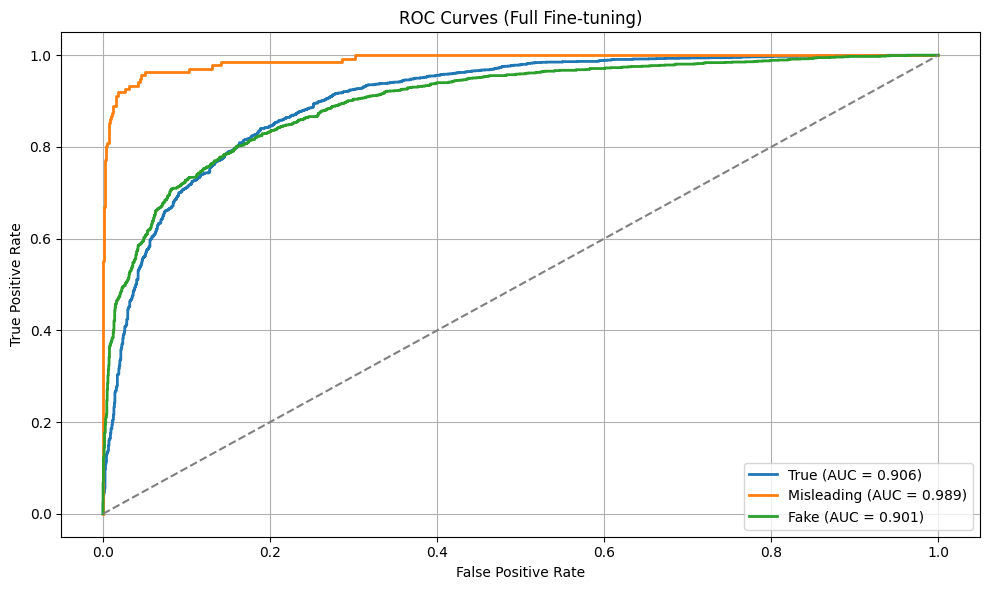

In [481]:
# plot ROC curves
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 6))
for i, name in enumerate(label_names):
    plt.plot(fpr[i], tpr[i], lw=2, label=f"{name} (AUC = {roc_auc[i]:.3f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Full Fine-tuning)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

Plot precision-recall curves

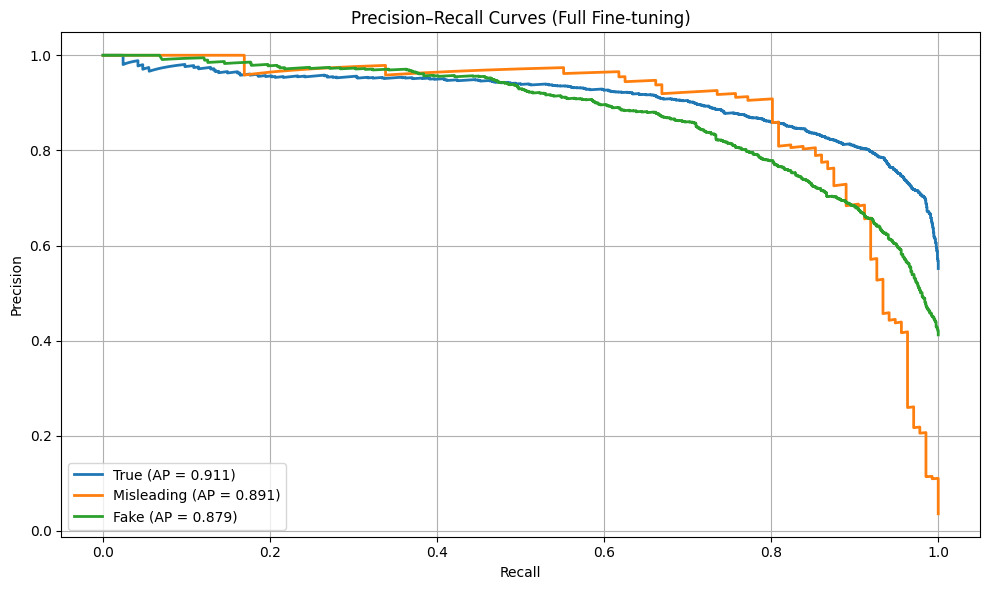

In [482]:
# plot precision-recall curves
precision, recall, avg_precision = {}, {}, {}
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], all_probs[:, i])
    avg_precision[i] = average_precision_score(y_true_bin[:, i], all_probs[:, i])

plt.figure(figsize=(10, 6))
for i, name in enumerate(label_names):
    plt.plot(recall[i], precision[i], lw=2, label=f"{name} (AP = {avg_precision[i]:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves (Full Fine-tuning)")
plt.legend(loc="lower left")
plt.grid(True)
plt.tight_layout()
plt.show()

Save BERT-ResNet fusion model

In [483]:
torch.save(fusion_model.state_dict(), "bert_resnet_fusion.pt")

Ablation: dropout = 0.3

BERT model

In [484]:
class TextClassifier(nn.Module):
    def __init__(self, text_model_name="bert-base-uncased", num_labels=3, freeze_bert=False):
        super().__init__()
        self.bert = BertModel.from_pretrained(text_model_name)
        self.config = self.bert.config  
        hidden = self.bert.config.hidden_size
        self.classifier = nn.Linear(hidden, num_labels)

        if freeze_bert:
            for p in self.bert.parameters():
                p.requires_grad = False

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.pooler_output
        return self.classifier(pooled)

# LoRA config
config = LoraConfig(
    task_type=TaskType.FEATURE_EXTRACTION,
    r=8,
    lora_alpha=32,
    lora_dropout=0.3,
    target_modules=["query", "value"]
)

# apply LoRA to BERT first, not to classifier
bert = BertModel.from_pretrained("bert-base-uncased")
bert = get_peft_model(bert, config)

# wrap the LoRA-BERT in classifier
text_model = TextClassifier(num_labels=3)
text_model.bert = bert


ResNet model

In [485]:
class ImageClassifier(nn.Module):
    def __init__(self, num_labels=3):
        super().__init__()
        self.backbone = resnet50(weights=ResNet50_Weights.DEFAULT)
        in_feat = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.Linear(in_feat, num_labels)
        )
        
        # Freeze all params
        for p in self.backbone.parameters():
            p.requires_grad = False

        # Unfreeze last residual block
        for name, p in self.backbone.layer4.named_parameters():
            p.requires_grad = True
        # Unfreeze final classifier
        for p in self.backbone.fc.parameters():
            p.requires_grad = True

    def forward(self, image):
        return self.backbone(image)


Fusion

In [486]:

class BertResNetLateFusion(nn.Module):
    def __init__(self, 
                 text_model_path="bert_text_only.pt", 
                 image_model_path="resnet_image_only.pt", 
                 num_classes=3, 
                 freeze_encoders=True):
        super().__init__()
        self.text_dropout = nn.Dropout(0.3)  
        self.img_dropout = nn.Dropout(0.3)

        # Load pretrained BERT
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.text_fc = nn.Linear(768, 512)  # reduce to 512-dim

        if text_model_path:
            try:
                text_state = torch.load(text_model_path, map_location="cpu")
                # Load only BERT weights (not classifier)
                bert_weights = {k.replace('bert.', ''): v for k, v in text_state.items() if 'bert.' in k}
                self.bert.load_state_dict(bert_weights, strict=False)
                print("Loaded pretrained BERT weights")
            except Exception as e:
                print(f"Could not load BERT weights: {e}")

        # Load pretrained ResNet
        resnet = models.resnet50(weights=None)
        resnet.fc = nn.Identity()
        self.resnet = resnet
        self.img_fc = nn.Linear(2048, 512)

        if image_model_path:
            try:
                image_state = torch.load(image_model_path, map_location="cpu")
                resnet_weights = {k.replace('resnet.', ''): v for k, v in image_state.items() if 'resnet.' in k}
                self.resnet.load_state_dict(resnet_weights, strict=False)
                print("Loaded pretrained ResNet weights")
            except Exception as e:
                print(f"Could not load ResNet weights: {e}")

        # Freeze fine-tuned encoders
        if freeze_encoders:
            for p in self.bert.parameters():
                p.requires_grad = False
            for p in self.resnet.parameters():
                p.requires_grad = False

            # Unfreeze last layers
            for name, param in self.bert.named_parameters():
                if "encoder.layer.11" in name or "pooler" in name:
                    param.requires_grad = True

            for name, param in self.resnet.named_parameters():
                if "layer4" in name:
                    param.requires_grad = True

        # Fusion head
        self.alpha = nn.Parameter(torch.tensor(0.5))  # learnable fusion weight
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )

    # Forward pass
    def forward(self, input_ids, attention_mask, image):
        # Text embedding
        text_out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        text_emb = self.text_fc(text_out.pooler_output)
        text_emb = self.text_dropout(text_emb)

        # Image embedding
        img_emb = self.img_fc(self.resnet(image))
        img_emb = self.img_dropout(img_emb)

        # Weighted fusion
        fused_emb = self.alpha * text_emb + (1 - self.alpha) * img_emb
        logits = self.classifier(fused_emb)
        return logits


Train BERT

In [487]:
def evaluate_text_model(model, loader):
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = outputs.argmax(dim=1).cpu()
            all_p.extend(preds.cpu().numpy())
            all_l.extend(batch["label"].cpu().numpy())
            all_preds.extend(preds)
            all_labels.extend(labels.cpu())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(labels, preds, average='weighted')
    macro_f1 = f1_score(labels, preds, average='macro')
    avg_loss = total_loss/len(loader)
    return avg_loss, acc, f1, macro_f1


In [488]:
tr_loss = []
v_loss = []
ac = []
vac = []
f = []
vf = []
mac_f1 = []
vmac_f1 = []

def train_text_model(model, train_loader, val_loader, epochs=5, lr=1e-6): # decreased learning rate
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        all_preds, all_labels = [], []

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            preds = outputs.argmax(dim=1).detach().cpu()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu())

        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='weighted')
        macro_f1 = f1_score(all_labels, all_preds, average='macro')
        avg_loss = total_loss/len(train_loader)
        tr_loss.append(avg_loss)
        ac.append(acc)
        f.append(f1)
        mac_f1.append(macro_f1)
        print(f"Epoch {epoch+1} | Train Loss: {avg_loss:.4f}, Accuracy: {acc:.4f}, Weighted F1: {f1:.4f}, Macro F1: {macro_f1:.4f}")
        
        vloss, vacc, vf1, mf1 = evaluate_text_model(model, val_loader)
        v_loss.append(vloss)
        vac.append(vacc)
        vf.append(vf1)
        vmac_f1.append(mf1)
        print(f"Validation Loss: {vloss:.4f}, Accuracy: {vacc:.4f}, Weighted F1: {vf1:.4f}, Macro F1: {mf1:.4f}")
    return model


In [489]:
text_model = TextClassifier().to(device)
text_model = train_text_model(text_model, train_text_loader, val_text_loader)

Epoch 1: 100%|██████████| 1886/1886 [22:42<00:00,  1.38it/s]


Epoch 1 | Train Loss: 0.8507, Accuracy: 0.6330, Weighted F1: 0.6335, Macro F1: 0.5588
Validation Loss: 0.6267, Accuracy: 0.7248, Weighted F1: 0.7639, Macro F1: 0.6746


Epoch 2: 100%|██████████| 1886/1886 [22:04<00:00,  1.42it/s]


Epoch 2 | Train Loss: 0.5838, Accuracy: 0.7294, Weighted F1: 0.7303, Macro F1: 0.7008
Validation Loss: 0.5190, Accuracy: 0.7595, Weighted F1: 0.9444, Macro F1: 0.5556


Epoch 3: 100%|██████████| 1886/1886 [22:09<00:00,  1.42it/s]


Epoch 3 | Train Loss: 0.4971, Accuracy: 0.7603, Weighted F1: 0.7610, Macro F1: 0.7443
Validation Loss: 0.4727, Accuracy: 0.7792, Weighted F1: 0.8074, Macro F1: 0.4296


Epoch 4: 100%|██████████| 1886/1886 [21:59<00:00,  1.43it/s]


Epoch 4 | Train Loss: 0.4507, Accuracy: 0.7774, Weighted F1: 0.7779, Macro F1: 0.7738
Validation Loss: 0.4674, Accuracy: 0.7916, Weighted F1: 0.7148, Macro F1: 0.3926


Epoch 5: 100%|██████████| 1886/1886 [21:56<00:00,  1.43it/s]


Epoch 5 | Train Loss: 0.4211, Accuracy: 0.7922, Weighted F1: 0.7925, Macro F1: 0.7946
Validation Loss: 0.4671, Accuracy: 0.7937, Weighted F1: 0.9172, Macro F1: 0.9161


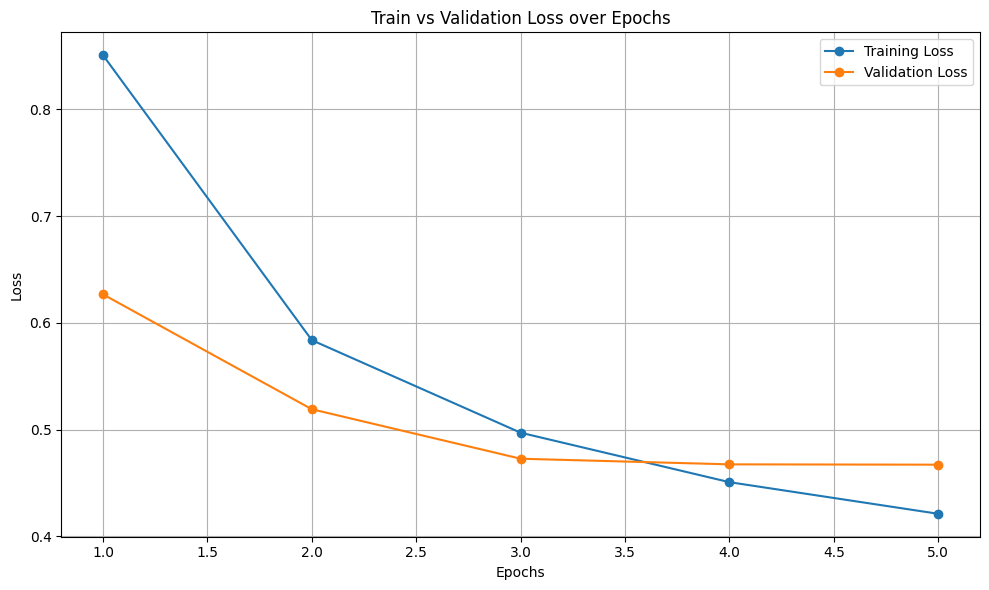

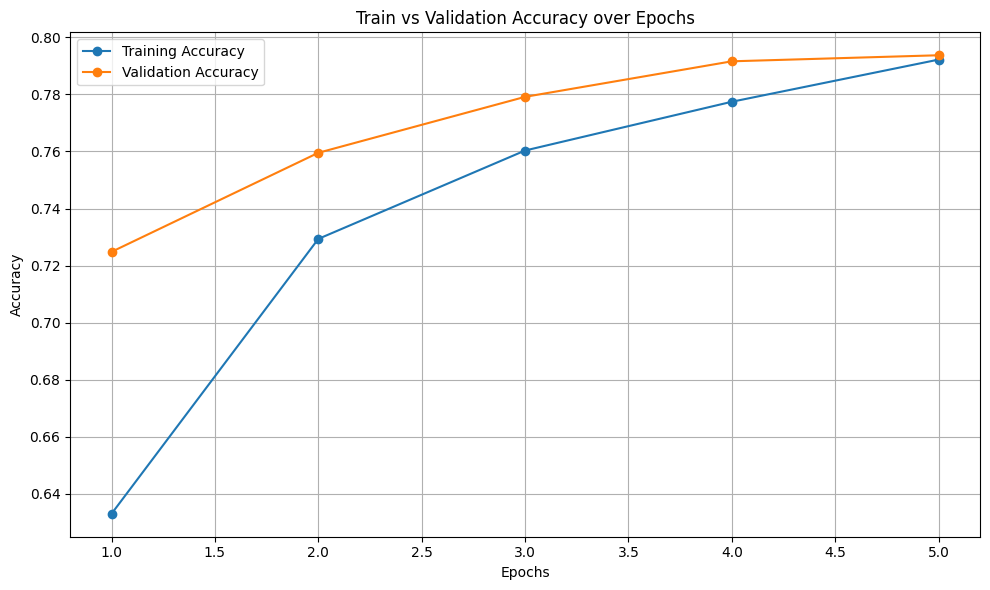

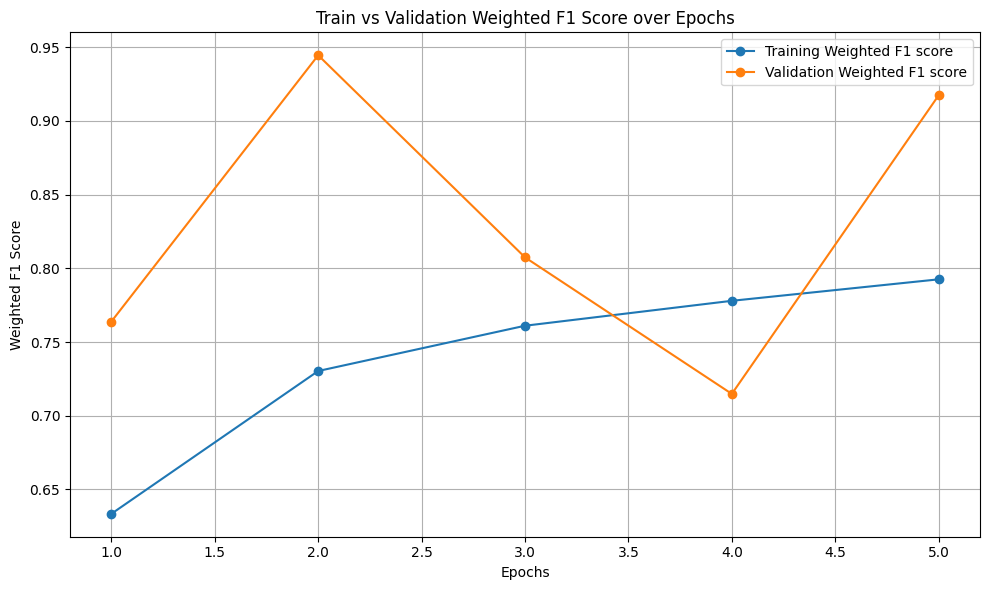

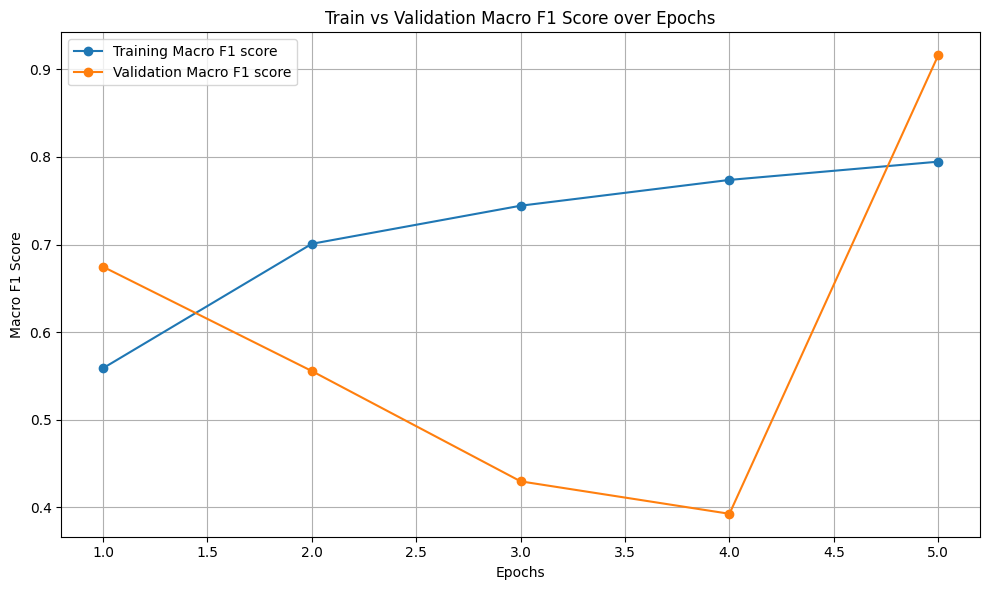

In [490]:
# Plots

# Training vs Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS+1), tr_loss, marker='o', label='Training Loss')
plt.plot(range(1, EPOCHS+1), v_loss, marker='o', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss over Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Train vs Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS+1), ac, marker='o', label='Training Accuracy')
plt.plot(range(1, EPOCHS+1), vac, marker='o', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy over Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Train vs Validation F1 Score
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS+1), f, marker='o', label='Training Weighted F1 score')
plt.plot(range(1, EPOCHS+1), vf, marker='o', label='Validation Weighted F1 score')
plt.xlabel('Epochs')
plt.ylabel('Weighted F1 Score')
plt.title('Train vs Validation Weighted F1 Score over Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Train vs Validation Macro F1 Score
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS+1), mac_f1, marker='o', label='Training Macro F1 score')
plt.plot(range(1, EPOCHS+1), vmac_f1, marker='o', label='Validation Macro F1 score')
plt.xlabel('Epochs')
plt.ylabel('Macro F1 Score')
plt.title('Train vs Validation Macro F1 Score over Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

BERT perfromance on Test set

In [491]:
# collect predictions and labels
all_preds, all_labels = [], []
test_loss, test_acc, test_f1, test_mf1 = evaluate_text_model(text_model, test_text_loader)
print("Perfromance of Text only BERT model on test data:")
print(f"Test loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}, Weighted F1: {test_f1:.4f}, Macro F1: {test_mf1:.4f}")

Perfromance of Text only BERT model on test data:
Test loss: 0.4887, Accuracy: 0.7932, Weighted F1: 0.5741, Macro F1: 0.5556


svae bert model for later

In [492]:
torch.save(text_model.state_dict(), "bert_text_only2.pt")

In [493]:
# define label names
label_names = ['True', 'Misleading', 'Fake']

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Collect predictions and labels
all_preds, all_labels = [], []

text_model.eval() 

loop = tqdm(test_loader, desc='Testing')
with torch.no_grad():
    for batch in loop:
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels = batch["label"].to(DEVICE)

        logits = text_model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(logits, dim=-1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print classification report
report = classification_report(all_labels, all_preds, target_names=label_names, digits=4)
print('\n=== Classification Report (BERT Model) ===\n')
print(report)

Testing: 100%|██████████| 236/236 [00:45<00:00,  5.23it/s]


=== Classification Report (BERT Model) ===

              precision    recall  f1-score   support

        True     0.8149    0.8313    0.8230      2081
  Misleading     0.7692    0.8824    0.8219       136
        Fake     0.7649    0.7344    0.7493      1555

    accuracy                         0.7932      3772
   macro avg     0.7830    0.8160    0.7981      3772
weighted avg     0.7926    0.7932    0.7926      3772



Train ResNet

In [494]:
def evaluate_image_model(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
    with torch.no_grad():
        for batch in loader:
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = outputs.argmax(dim=1).cpu()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(labels, preds, average='weighted')
    macro_f1 = f1_score(labels, preds, average='macro')
    avg_loss = total_loss/len(loader)
    return avg_loss, acc, f1, macro_f1

In [495]:
tr_loss = []
v_loss = []
ac = []
vac = []
f = []
vf = []
mac_f1 = []
vmac_f1 = []

def train_image_model(model, train_loader, val_loader, epochs=5, lr=1e-5): # reduced learning rate
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4) # added weight decay
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        all_preds, all_labels = [], []

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            optimizer.zero_grad()
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            preds = outputs.argmax(dim=1).detach().cpu()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu())

        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='weighted')
        macro_f1 = f1_score(all_labels, all_preds, average='macro')
        avg_loss = total_loss/len(train_loader)
        tr_loss.append(avg_loss)
        ac.append(acc)
        f.append(f1)
        mac_f1.append(macro_f1)
        print(f"Epoch {epoch+1} | Train Loss: {avg_loss:.4f}, Acc: {acc:.4f}, Weighted F1: {f1:.4f}, Macro F1: {macro_f1:.4f}")

        vloss, vacc, vf1, vmf1 = evaluate_image_model(model, val_loader)
        v_loss.append(vloss)
        vac.append(vacc)
        vf.append(vf1)
        vmac_f1.append(vmf1)
        print(f"Validation Loss: {vloss:.4f}, Accuracy: {vacc:.4f}, Weighted F1: {vf1:.4f}, Macro F1: {vmf1:.4f}")
    return model

In [496]:
image_model = ImageClassifier().to(device)
image_model = train_image_model(image_model, train_image_loader, val_image_loader)

Epoch 1: 100%|██████████| 1886/1886 [1:20:05<00:00,  2.55s/it]


Epoch 1 | Train Loss: 0.8805, Acc: 0.5411, Weighted F1: 0.5500, Macro F1: 0.4791
Validation Loss: 0.7512, Accuracy: 0.6143, Weighted F1: 0.4339, Macro F1: 0.4226


Epoch 2: 100%|██████████| 1886/1886 [1:20:52<00:00,  2.57s/it]


Epoch 2 | Train Loss: 0.7239, Acc: 0.6147, Weighted F1: 0.6181, Macro F1: 0.5663
Validation Loss: 0.6912, Accuracy: 0.6615, Weighted F1: 0.7605, Macro F1: 0.6975


Epoch 3: 100%|██████████| 1886/1886 [1:20:10<00:00,  2.55s/it]


Epoch 3 | Train Loss: 0.6730, Acc: 0.6473, Weighted F1: 0.6486, Macro F1: 0.6043
Validation Loss: 0.6745, Accuracy: 0.6742, Weighted F1: 0.7457, Macro F1: 0.8120


Epoch 4: 100%|██████████| 1886/1886 [1:19:24<00:00,  2.53s/it]


Epoch 4 | Train Loss: 0.6360, Acc: 0.6644, Weighted F1: 0.6652, Macro F1: 0.6272
Validation Loss: 0.6683, Accuracy: 0.6705, Weighted F1: 0.4912, Macro F1: 0.3684


Epoch 5: 100%|██████████| 1886/1886 [1:19:29<00:00,  2.53s/it]


Epoch 5 | Train Loss: 0.6154, Acc: 0.6733, Weighted F1: 0.6735, Macro F1: 0.6427
Validation Loss: 0.6732, Accuracy: 0.6832, Weighted F1: 1.0000, Macro F1: 1.0000


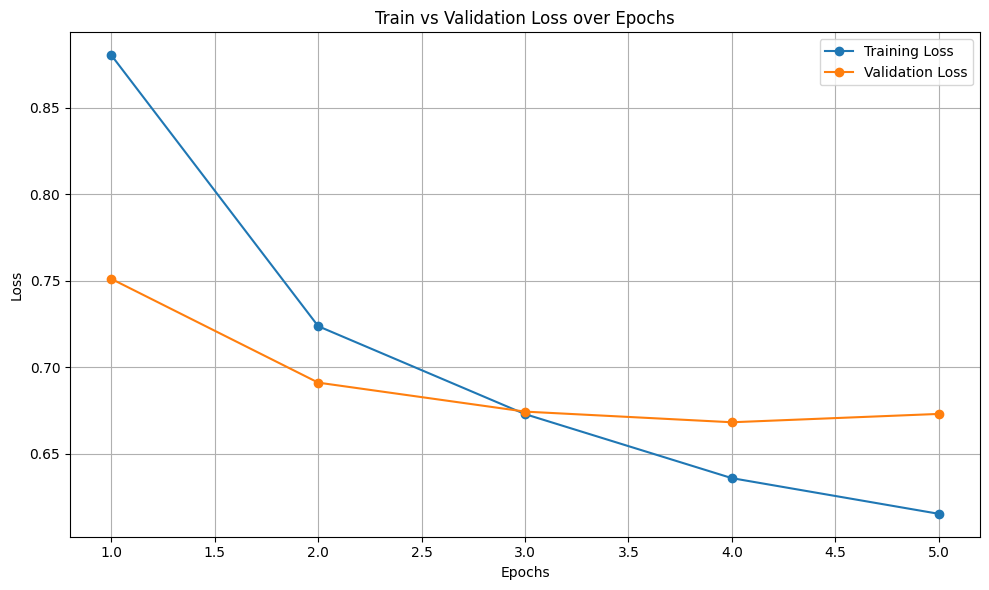

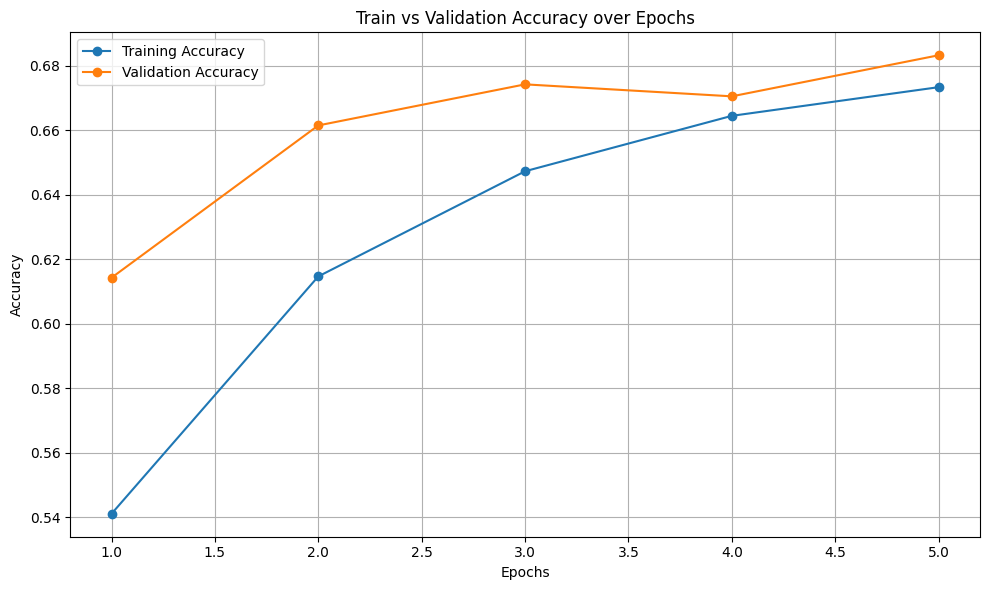

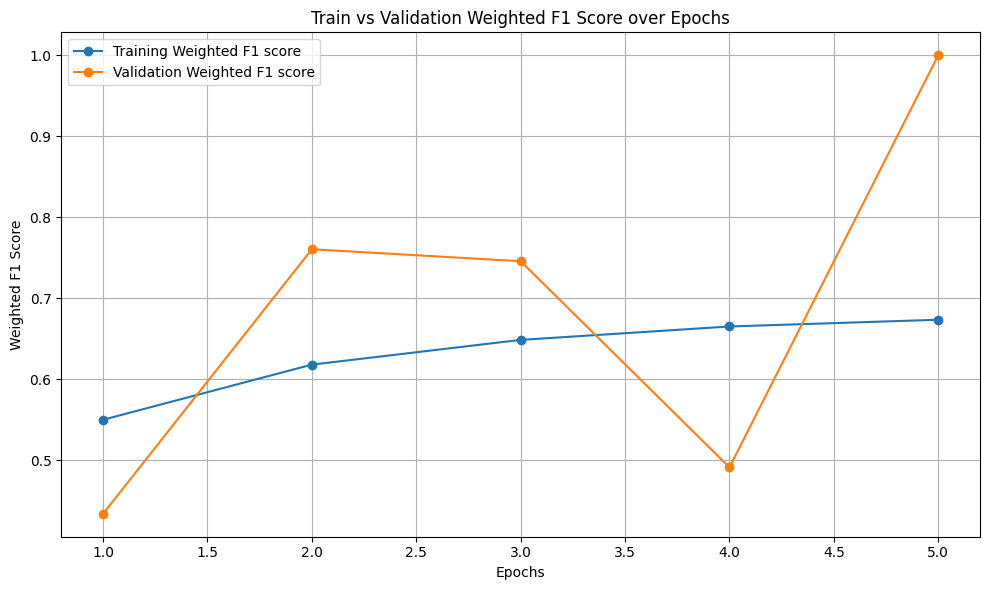

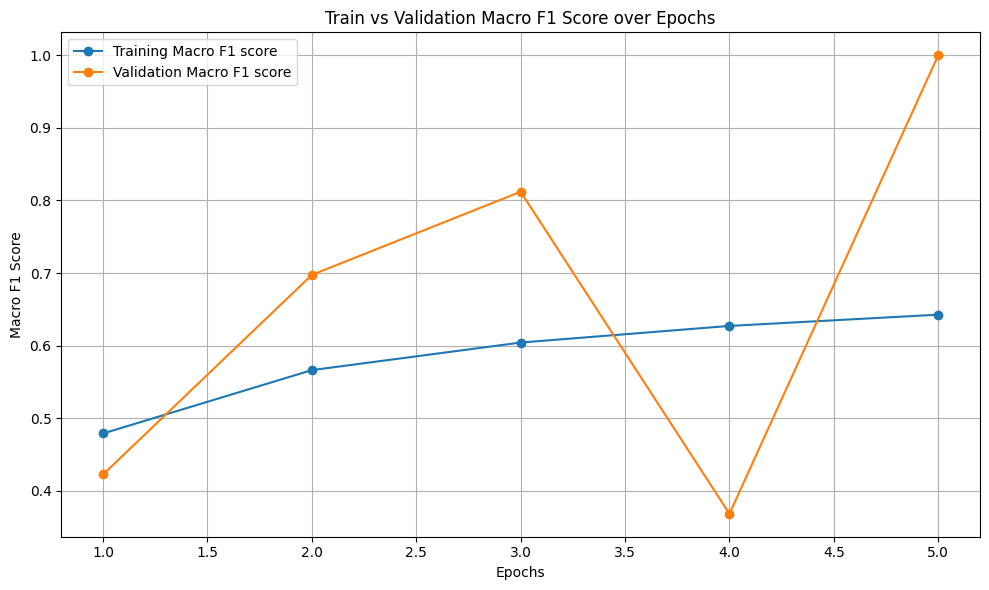

In [497]:
# plot loss, accuracy, f1

# Training vs Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS+1), tr_loss, marker='o', label='Training Loss')
plt.plot(range(1, EPOCHS+1), v_loss, marker='o', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss over Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Train vs Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS+1), ac, marker='o', label='Training Accuracy')
plt.plot(range(1, EPOCHS+1), vac, marker='o', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy over Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Train vs Validation F1 Score
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS+1), f, marker='o', label='Training Weighted F1 score')
plt.plot(range(1, EPOCHS+1), vf, marker='o', label='Validation Weighted F1 score')
plt.xlabel('Epochs')
plt.ylabel('Weighted F1 Score')
plt.title('Train vs Validation Weighted F1 Score over Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Train vs Validation Macro F1 Score
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS+1), mac_f1, marker='o', label='Training Macro F1 score')
plt.plot(range(1, EPOCHS+1), vmac_f1, marker='o', label='Validation Macro F1 score')
plt.xlabel('Epochs')
plt.ylabel('Macro F1 Score')
plt.title('Train vs Validation Macro F1 Score over Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

ResNet performance on Test set

In [498]:
# collect predictions and labels
all_preds, all_labels = [], []
tloss, tacc, tf1, tmf1 = evaluate_image_model(image_model, test_image_loader)
print("Perfromance of Image only ResNet model on test data:")
print(f"Test loss: {tloss:.4f}, Accuracy: {tacc:.4f}, Weighted F1: {tf1:.4f}, Macro F1: {tmf1:.4f}")

Perfromance of Image only ResNet model on test data:
Test loss: 0.6985, Accuracy: 0.6901, Weighted F1: 0.7333, Macro F1: 0.7333


In [499]:
# Define label names
label_names = ['True', 'Misleading', 'Fake']

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Collect predictions and labels
all_preds, all_labels = [], []

image_model.eval()  # ensure dropout/bn layers are in eval mode

loop = tqdm(test_loader, desc='Testing')
with torch.no_grad():
    for batch in loop:
        batch = {k: v.to(DEVICE) for k, v in batch.items()}
        
        logits = image_model(batch["image"])
        
        preds = torch.argmax(logits, dim=-1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch["label"].cpu().numpy())

# Print classification report
report = classification_report(all_labels, all_preds, target_names=label_names, digits=4)
print('\n=== Classification Report (ResNet Model) ===\n')
print(report)

Testing: 100%|██████████| 236/236 [08:55<00:00,  2.27s/it]


=== Classification Report (ResNet Model) ===

              precision    recall  f1-score   support

        True     0.7124    0.8227    0.7636      2081
  Misleading     0.4775    0.7794    0.5922       136
        Fake     0.6957    0.5132    0.5907      1555

    accuracy                         0.6935      3772
   macro avg     0.6285    0.7051    0.6488      3772
weighted avg     0.6971    0.6935    0.6861      3772



svae ResNet model

In [500]:
torch.save(image_model.state_dict(), "resnet_image_only2.pt")

Train fusion model

In [501]:
def evaluate_fusion_model(model, loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask, images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = outputs.argmax(dim=1).cpu()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    avg_loss = total_loss/len(loader)
    return avg_loss, acc, f1, macro_f1

In [502]:
tr_loss = []
v_loss = []
ac = []
vac = []
f = []
vf = []
mac_f1 = []
vmac_f1 = []

def train_fusion_model(model, train_loader, val_loader, epochs=5, lr=1e-6): # reduced learning rate
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=1e-4) # added weight decay
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        all_preds, all_labels = [], []

        for batch in tqdm(train_loader, desc=f"Fusion Epoch {epoch+1}"):
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask, images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            preds = outputs.argmax(dim=1).detach().cpu()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu())

        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='weighted')
        macro_f1 = f1_score(all_labels, all_preds, average='macro')
        avg_loss = total_loss/len(train_loader)
        tr_loss.append(avg_loss)
        ac.append(acc)
        f.append(f1)
        mac_f1.append(macro_f1)
        print(f"Epoch {epoch+1} | Train Loss: {avg_loss:.4f}, Acc: {acc:.4f}, Weighted F1: {f1:.4f}, Macro F1: {macro_f1:.4f}")

        vloss, vacc, vf1, vmf1 = evaluate_fusion_model(model, val_loader)
        v_loss.append(vloss)
        vac.append(vacc)
        vf.append(vf1)
        vmac_f1.append(vmf1)
        print(f"Validation Loss: {vloss:.4f}, Accuracy: {vacc:.4f}, Weighted F1: {vf1:.4f}, Macro F1: {vmf1:.4f}")
        print(f"Current α: {fusion_model.alpha.item():.3f}")
    return model

In [503]:
fusion_model = BertResNetLateFusion(
    text_model_path="bert_text_only2.pt",
    image_model_path="resnet_image_only2.pt",
    num_classes=3,
    freeze_encoders=True 
)

fusion_model = train_fusion_model(fusion_model, train_loader, val_loader)

Loaded pretrained BERT weights
Loaded pretrained ResNet weights


Fusion Epoch 1: 100%|██████████| 1886/1886 [1:27:16<00:00,  2.78s/it]


Epoch 1 | Train Loss: 0.7360, Acc: 0.7478, Weighted F1: 0.7500, Macro F1: 0.7204
Validation Loss: 0.5211, Accuracy: 0.7951, Weighted F1: 0.7938, Macro F1: 0.7944
Current α: 0.502


Fusion Epoch 2: 100%|██████████| 1886/1886 [1:30:31<00:00,  2.88s/it]


Epoch 2 | Train Loss: 0.4448, Acc: 0.8000, Weighted F1: 0.8001, Macro F1: 0.8095
Validation Loss: 0.4602, Accuracy: 0.7951, Weighted F1: 0.7951, Macro F1: 0.7956
Current α: 0.503


Fusion Epoch 3: 100%|██████████| 1886/1886 [1:36:18<00:00,  3.06s/it]


Epoch 3 | Train Loss: 0.4083, Acc: 0.7998, Weighted F1: 0.8001, Macro F1: 0.8135
Validation Loss: 0.4719, Accuracy: 0.7961, Weighted F1: 0.7958, Macro F1: 0.7963
Current α: 0.504


Fusion Epoch 4: 100%|██████████| 1886/1886 [1:39:07<00:00,  3.15s/it]


Epoch 4 | Train Loss: 0.4004, Acc: 0.8012, Weighted F1: 0.8015, Macro F1: 0.8180
Validation Loss: 0.4735, Accuracy: 0.7967, Weighted F1: 0.7962, Macro F1: 0.7939
Current α: 0.504


Fusion Epoch 5: 100%|██████████| 1886/1886 [1:42:20<00:00,  3.26s/it]


Epoch 5 | Train Loss: 0.3972, Acc: 0.8029, Weighted F1: 0.8031, Macro F1: 0.8197
Validation Loss: 0.4794, Accuracy: 0.7990, Weighted F1: 0.7987, Macro F1: 0.8000
Current α: 0.504


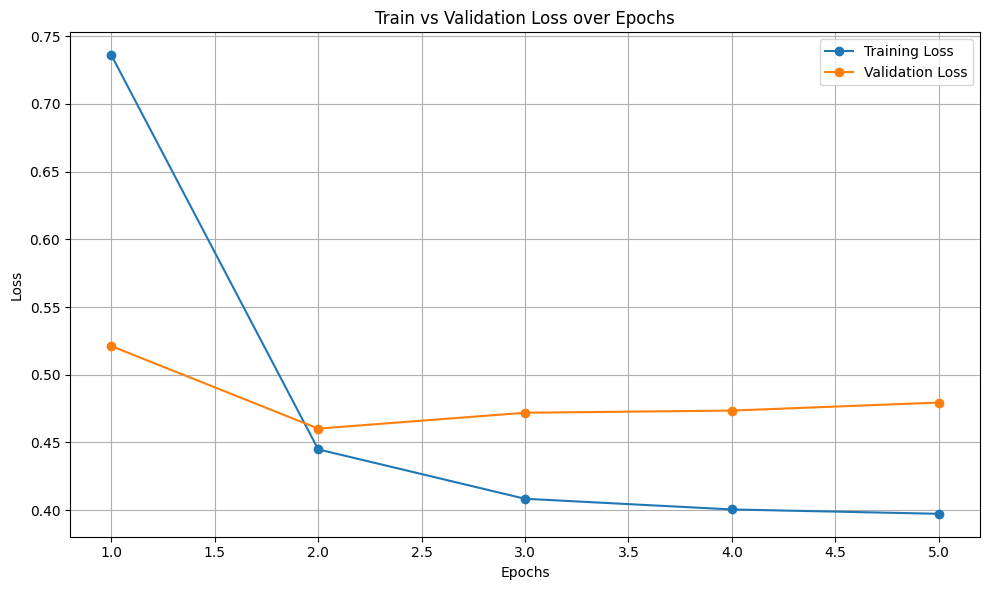

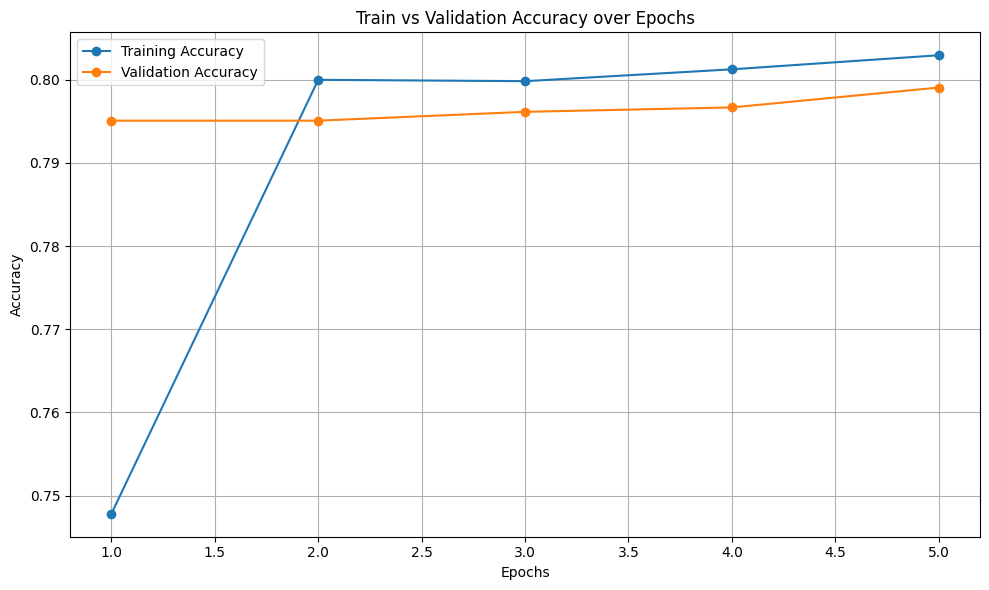

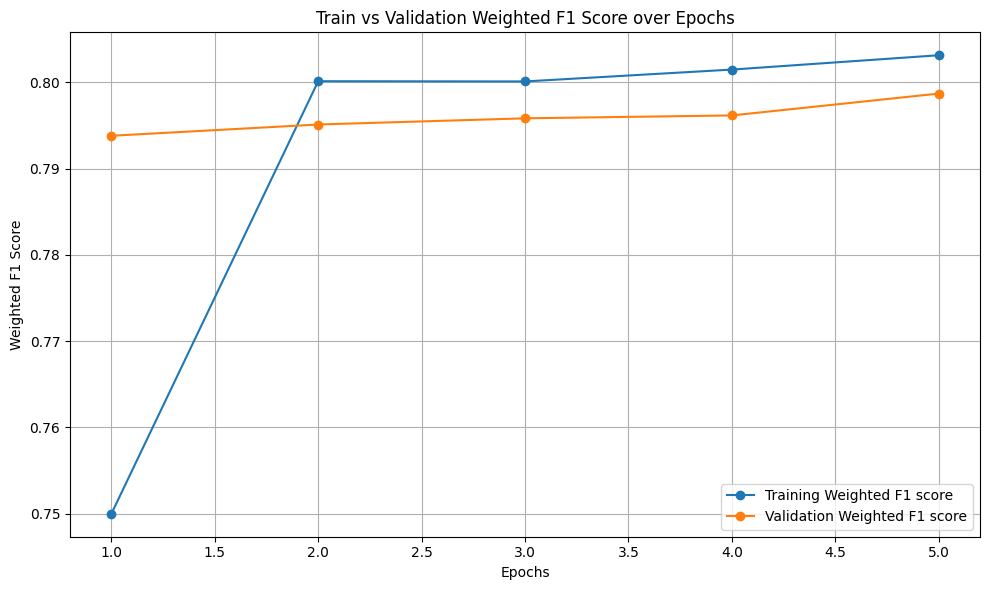

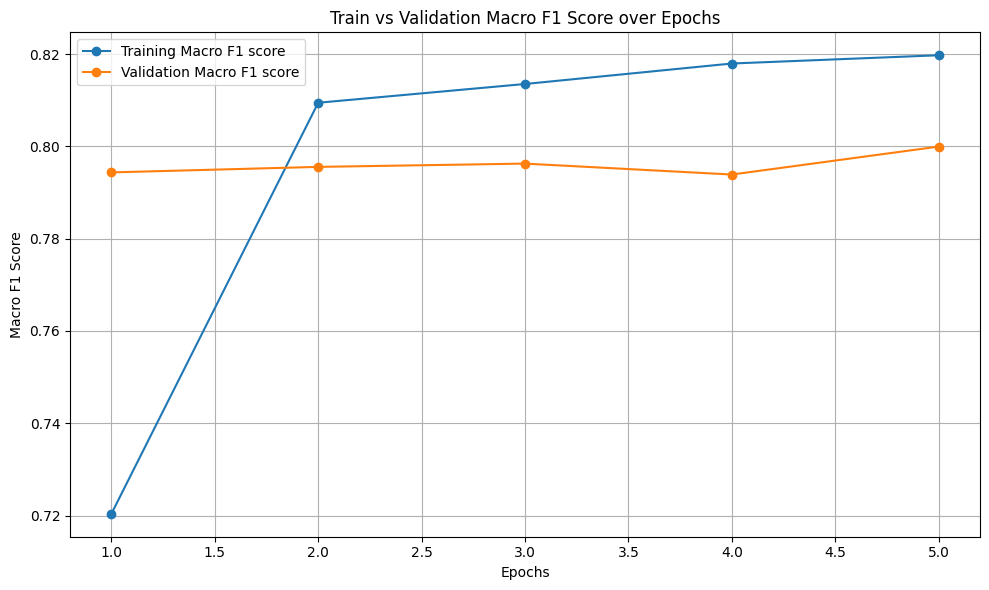

In [504]:
# plot loss, accuracy, f1

# Training vs Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS+1), tr_loss, marker='o', label='Training Loss')
plt.plot(range(1, EPOCHS+1), v_loss, marker='o', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss over Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Train vs Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS+1), ac, marker='o', label='Training Accuracy')
plt.plot(range(1, EPOCHS+1), vac, marker='o', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy over Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Train vs Validation F1 Score
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS+1), f, marker='o', label='Training Weighted F1 score')
plt.plot(range(1, EPOCHS+1), vf, marker='o', label='Validation Weighted F1 score')
plt.xlabel('Epochs')
plt.ylabel('Weighted F1 Score')
plt.title('Train vs Validation Weighted F1 Score over Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Train vs Validation Macro F1 Score
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS+1), mac_f1, marker='o', label='Training Macro F1 score')
plt.plot(range(1, EPOCHS+1), vmac_f1, marker='o', label='Validation Macro F1 score')
plt.xlabel('Epochs')
plt.ylabel('Macro F1 Score')
plt.title('Train vs Validation Macro F1 Score over Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Fusion model performance on test set

In [505]:
# collect predictions and labels
all_preds, all_labels = [], []
tloss, tacc, tf1, tmf1 = evaluate_fusion_model(fusion_model, test_loader)
print("Perfromance of Image and Text BERT-ResNet Fusion model on test data:")
print(f"Test loss: {tloss:.4f}, Accuracy: {tacc:.4f}, Weighted F1: {tf1:.4f}, Macro F1: {tmf1:.4f}")

Perfromance of Image and Text BERT-ResNet Fusion model on test data:
Test loss: 0.4973, Accuracy: 0.7951, Weighted F1: 0.7943, Macro F1: 0.8009


In [506]:
# Define label names
label_names = ['True', 'Misleading', 'Fake']

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Collect predictions and labels
all_preds, all_labels = [], []

fusion_model.eval()  

loop = tqdm(test_loader, desc='Testing')
with torch.no_grad():
    for batch in loop:
        batch = {k: v.to(DEVICE) for k, v in batch.items()}
        
        logits = fusion_model(batch["input_ids"], batch["attention_mask"], batch["image"])
        
        preds = torch.argmax(logits, dim=-1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch["label"].cpu().numpy())

# Print classification report
report = classification_report(all_labels, all_preds, target_names=label_names, digits=4)
print('\n=== Classification Report (ResNet Model) ===\n')
print(report)

Testing: 100%|██████████| 236/236 [12:40<00:00,  3.22s/it]


=== Classification Report (ResNet Model) ===

              precision    recall  f1-score   support

        True     0.8152    0.8376    0.8263      2081
  Misleading     0.7792    0.8824    0.8276       136
        Fake     0.7696    0.7325    0.7506      1555

    accuracy                         0.7959      3772
   macro avg     0.7880    0.8175    0.8015      3772
weighted avg     0.7951    0.7959    0.7951      3772



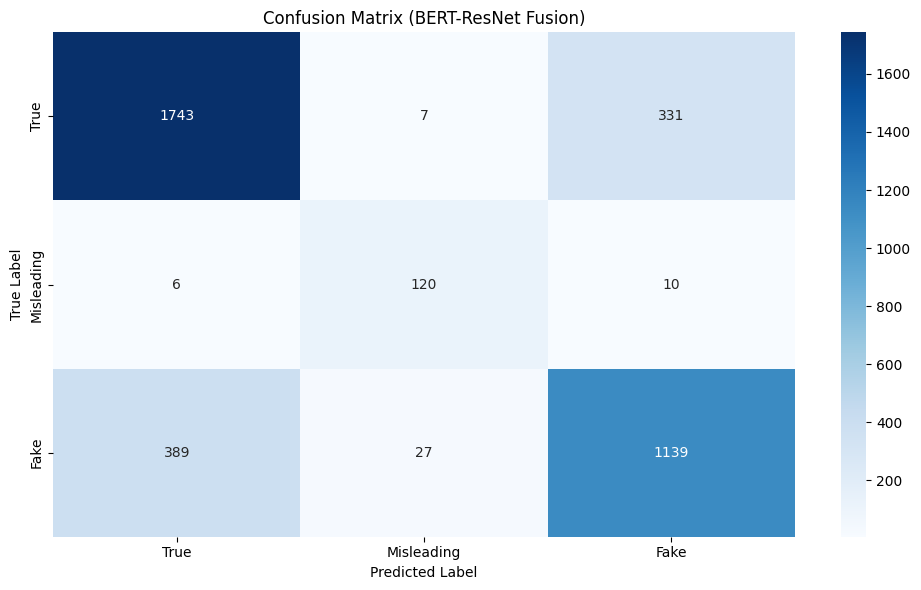

In [507]:
# plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (BERT-ResNet Fusion)')
plt.tight_layout()
plt.show()

Plot ROC-AUC curves

In [508]:
# binarize labels for ROC and precision-recall curves
y_true_bin = label_binarize(all_labels, classes=[0, 1, 2])
n_classes = y_true_bin.shape[1]

# get prediction probabilities
all_probs = []
loop = tqdm(test_loader, desc='Collecting probabilities')
with torch.no_grad():
    for batch in loop:
        batch = {k: v.to(DEVICE) for k, v in batch.items()}
        logits = model(batch["input_ids"], batch["attention_mask"], batch["image"])
        probs = torch.softmax(logits, dim=-1)
        all_probs.extend(probs.cpu().numpy())

all_probs = np.array(all_probs)

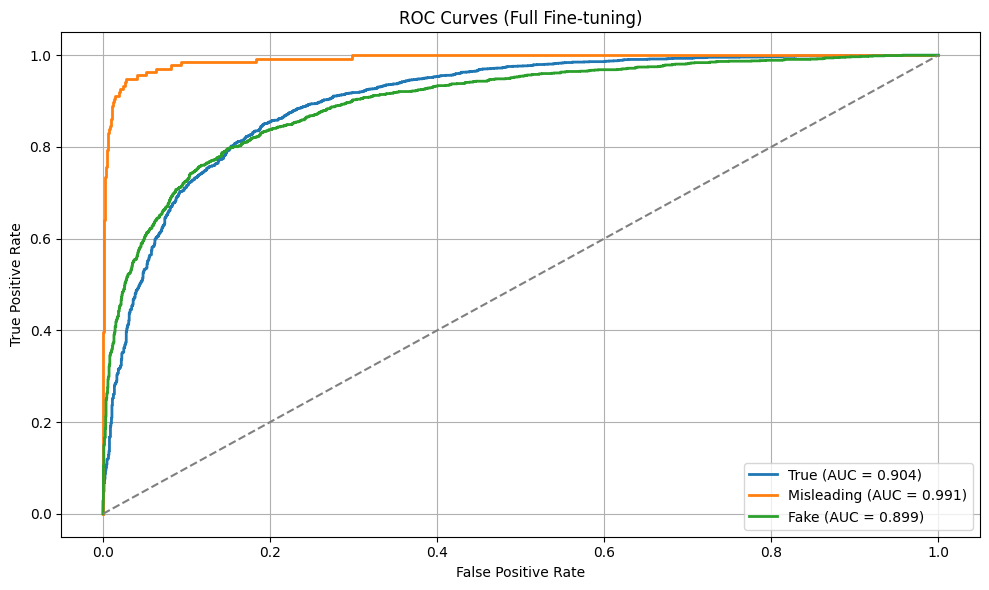

In [509]:
# plot ROC curves
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 6))
for i, name in enumerate(label_names):
    plt.plot(fpr[i], tpr[i], lw=2, label=f"{name} (AUC = {roc_auc[i]:.3f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Full Fine-tuning)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

Plot precision-recall curves

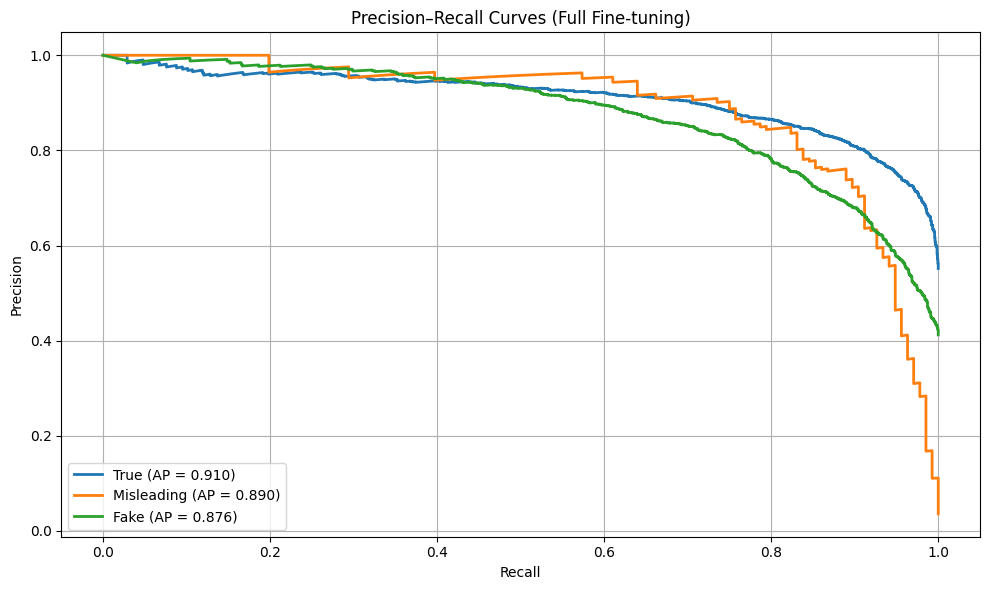

In [510]:
# plot precision-recall curves
precision, recall, avg_precision = {}, {}, {}
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], all_probs[:, i])
    avg_precision[i] = average_precision_score(y_true_bin[:, i], all_probs[:, i])

plt.figure(figsize=(10, 6))
for i, name in enumerate(label_names):
    plt.plot(recall[i], precision[i], lw=2, label=f"{name} (AP = {avg_precision[i]:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves (Full Fine-tuning)")
plt.legend(loc="lower left")
plt.grid(True)
plt.tight_layout()
plt.show()